---
# Group Epochs

In [1]:
from linescanning import (
    utils,
    plotting,
    fitting,
    preproc,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import holeresponse as hr
opj = os.path.join

In [2]:
# import subject dictionary containing useful information
subj_obj = hr.utils.SubjectsDict()
subj_obj.get_colors()

['#1B9E77', '#D95F02', '#4c75ff']

In [3]:
# get h5-file
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
repo_dir = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse"

incl_subjs = subj_obj.get_subjects()
excl = [
    "sub-003",
    "sub-008",
    "sub-014"
]

h5_files = []
for i in incl_subjs:
    if not i in excl:
        ses = subj_obj.get_session(i)
        h5 = utils.FindFiles(opj(deriv, "lsprep", i), extension="h5").files

        if len(h5)>0:
            h5_filt = utils.get_file_from_substring([f"ses-{ses}"], h5)
            h5_files.append(h5_filt)

h5_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-001/sub-001_ses-3_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-002/sub-002_ses-3_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-005/sub-005_ses-2_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-006/sub-006_ses-3_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-4_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-011/sub-011_ses-2_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-013/sub-013_ses-2_desc-preproc_bold.h5']

plotting 'sub-001'
plotting 'sub-002'
plotting 'sub-003'
plotting 'sub-005'
plotting 'sub-006'
plotting 'sub-010'
plotting 'sub-011'
plotting 'sub-013'
plotting 'sub-014'


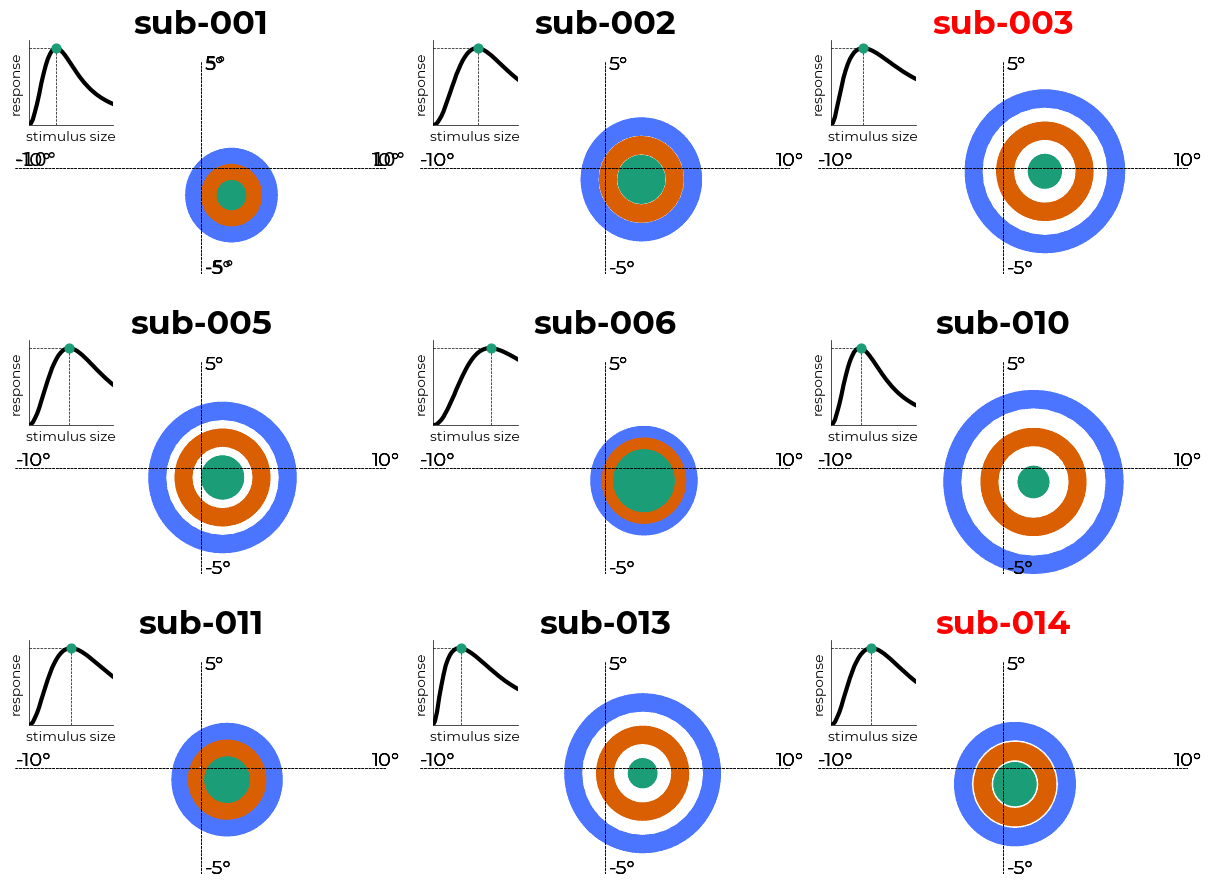

In [4]:
%matplotlib inline
subj_list = subj_obj.get_subjects()
ncols = 3
nrows = int(np.ceil(len(subj_list)/ncols))

fig,axs = plt.subplots(
    ncols=ncols, 
    nrows=nrows,
    figsize=(ncols*4,nrows*3), 
    constrained_layout=True
)

for ix,ax in enumerate(axs.flatten()):

    if (ix+1)>len(subj_list):
        # remove obsolete axes
        ax.remove()
    else:
        sub = subj_list[ix]
        print(f"plotting '{sub}'")
        png_obj = hr.viz.StimPNGs(sub)

        if sub in excl:
            f_col = "r"
        else:
            f_col = "k"
            
        png_obj.generate_composite(
            axs=ax, 
            annotate=True, 
            title={
                "title": sub, 
                "fontweight": "bold",
                "color": f_col
            },
            add_srf=True,
            srf_kw={
                "x_label": "stimulus size",
                "y_label": "response",
                "font_size": 10
            }
        )

# hr.viz._save_figure(fig, fname="group_desc-composite_stims", overwrite=True)

In [5]:
# png_obj = hr.viz.StimPNGs(sub)
# png_obj.generate_composite(
#     # axs=ax, 
#     annotate=True, 
#     title={
#         "title": "sub-001", 
#         "fontweight": "bold"
#     },
#     add_srf=True,
#     srf_kw={
#         "x_label": "stimulus size",
#         "y_label": "response",
#         "font_size": 14
#     },
#     normalize=True
# )

In [21]:
h5_tmp = hr.data.H5Parser(
    h5_files[0],
    verbose=True,
    compartments=20,
    # resample_kws={
    #     "preserve_range": True
    # }
)

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-001/sub-001_ses-3_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
Making 20 GM-compartments
Making 5 WM-compartments
Done with 'sub-001'



In [24]:
h5_tmp.df_avg
sub_ep = fitting.Epoch(
    h5_tmp.df_avg,
    h5_tmp.df_onsets,
    TR=0.105,
    interval=[-2,14]
)
sub_df = sub_ep.df_epoch.copy()
sub_df.head()

gm        wm
subject task run event_type epoch t                            
001     SRFb 2   act        0     -2.000000  0.016151 -0.351662
                                  -1.894737  0.157061 -1.082222
                                  -1.789474  0.347514  0.353779
                                  -1.684211  1.023862  0.481741
                                  -1.578947  1.262433  0.245436

In [28]:
pd.DataFrame(sub_df.groupby(["event_type","epoch","t"]).mean()["gm"])

gm
event_type epoch t                   
act        0     -2.000000   0.016151
                 -1.894737   0.157061
                 -1.789474   0.347514
                 -1.684211   1.023862
                 -1.578947   1.262433
...                               ...
suppr_2    4      13.473684 -0.831001
                  13.578947 -1.679910
                  13.684211 -1.297058
                  13.789474 -1.043451
                  13.894737 -1.342598

[2280 rows x 1 columns]

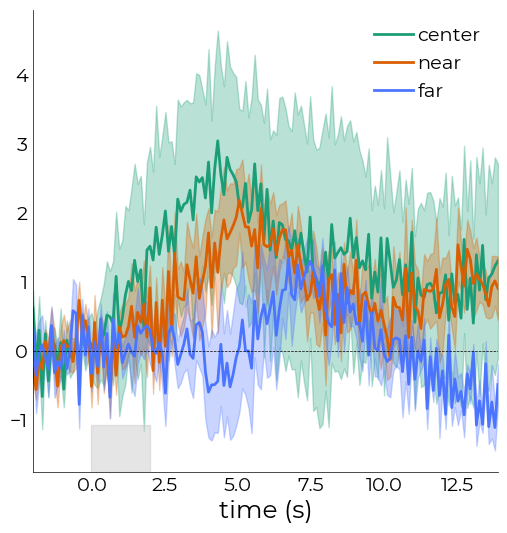

In [30]:
hr.viz.PlotEpochProfiles(
    sub_df.groupby(["event_type","epoch","t"]).mean()["gm"],
    # axs=ax,
    ev_names=["center","near","far"],
    cm=subj_obj.get_colors()
)

In [6]:
# parse h5-files
import pickle
data_dir = opj(os.path.dirname(hr.viz._save_figure(None, return_figdir=True)), "data")
h5_pkl = opj(data_dir, "h5_parser.pkl")
overwrite = False

if not os.path.exists(h5_pkl) or overwrite:
    h5_obj = hr.data.H5Parser(
        h5_files,
        verbose=True,
        compartments=20,
        # resample_kws={
        #     "preserve_range": True
        # }
    )

    print(f"Writing object to '{h5_pkl}'")
    with open(h5_pkl, 'wb') as handle:
        pickle.dump(h5_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print(f"Reading from '{h5_pkl}'")
    with open(h5_pkl, 'rb') as handle:
        h5_obj = pickle.load(handle)

Reading from '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/h5_parser.pkl'


In [7]:
# bijanzadeh = hr.viz.BijanzadehFigures()

In [8]:
# fname = opj(repo_dir, "images", "Fig3_bijanzadeh_orig_panel.pdf")
# fname2 = opj(repo_dir, "images", "Fig3c_bijanzadeh_2018.pdf")

# # original
# img1 = hr.utils.read_pdf_image(fname)
# img2 = hr.utils.read_pdf_image(fname2)

In [9]:

# fig,axs = plt.subplots(ncols=2, figsize=(20,10))
# axs[0].imshow(img1)
# plotting.conform_ax_to_obj(ax=axs[0], title={"title": "original", "fontweight": "bold"})

# # custom
# axs[1].imshow(img2)
# # plotting.conform_ax_to_obj(
# #     ax=axs[1],
# #     add_vline={
# #         "pos": 135,
# #         "color": "r",
# #         "lw": 2,
# #         "ls": "solid"
# #     },
# #     add_hline={
# #         "pos": [8,24,88,109,154,195,233],
# #         "color": "k",
# #         "lw": [2,1,1,1,1,1,2],
# #         "ls": ["solid","dashed","dashed","solid","solid","dashed","solid"]
# #     },
# #     title={
# #         "title": "custom", 
# #         "fontweight": "bold"
# #     },
# # )

# # axs[1].set_xticks(axs[1].get_xticks()+5)
# x_lbl_pos = [0,45, 90, 136, 181, 227, 275]
# axs[1].set_xticks(x_lbl_pos)
# axs[1].set_xticklabels(np.arange(-100,200*1.1, step=50, dtype=int))
# axs[1].set_yticklabels(["{:6.1f}".format(i) for i in np.arange(-0.2,1.4, step=0.2)])
# axs[1].set_yticklabels(["{:6.1f}".format(i) for i in np.arange(-0.2,1.4, step=0.2)])


# plt.show()

## Epochs

### Epoch average over ribbon

In [12]:
sub_ep = fitting.Epoch(
    h5_obj.df_avg,
    h5_obj.df_onsets,
    TR=0.105,
    interval=[-2,14]
)
sub_df = sub_ep.df_epoch.copy()
sub_df.head()

0
subject task run event_type epoch t                  
001     SRFb 2   act        0     -2.000000 -0.026940
                                  -1.894737 -0.073467
                                  -1.789474  0.316497
                                  -1.684211  0.987692
                                  -1.578947  1.208214

In [173]:
avg_ev = sub_df.groupby(["subject","event_type","epoch","t"]).mean()
avg_ev.head()


0
subject event_type epoch t                  
001     act        0     -2.000000 -0.026940
                         -1.894737 -0.073467
                         -1.789474  0.316497
                         -1.684211  0.987692
                         -1.578947  1.208214

### Epoch X-compartment model (superficial, middle, deep)

In [174]:
comp_ep = fitting.Epoch(
    h5_obj.df_comps,
    h5_obj.df_onsets,
    TR=0.105,
    interval=[-2,14]
)
comp_df = comp_ep.df_epoch.copy()
comp_df.head()

0         1         2  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000 -2.193376 -2.223086 -2.089393   
                                  -1.894737  1.518197  1.555356  1.388141   
                                  -1.789474 -1.426782 -1.685559 -0.521060   
                                  -1.684211  1.996490  2.067413  1.748260   
                                  -1.578947  0.228764  0.273227  0.073145   

                                                    3         4         5  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000 -1.772996 -0.543080  0.686836   
                                  -1.894737  1.149171  0.551429 -0.046313   
                                  -1.789474  0.532410  1.030737  1.529063   
                                  -1.684211  1.424309  1.076361  0.728414   
                                  -1.578947  0.231601  2.182745  4.133890   

                                                    6         7         8  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000  0.452251  0.131519  0.141904   
                                  -1.894737  0.338816  0.781760  0.707329   
                                  -1.789474  0.495914 -0.627321 -0.694527   
                                  -1.684211  1.342404  2.012979  2.349875   
                                  -1.578947  3.064188  1.816791  2.151233   

                                                    9        10        11  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000  0.279642  0.372797  0.421371   
                                  -1.894737  0.433907 -0.015846 -0.641930   
                                  -1.789474 -0.355568 -0.265303 -0.423733   
                                  -1.684211  2.558433  2.246464  1.413968   
                                  -1.578947  3.094077  2.711833  1.004503   

                                                   12        13        14  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000  0.760854  1.856702  2.816580   
                                  -1.894737 -1.173084 -1.457424 -1.680696   
                                  -1.789474 -0.001477  1.930561  3.681901   
                                  -1.684211  0.631686 -0.020040 -0.650449   
                                  -1.578947 -0.292041 -0.520539 -0.679713   

                                                   15        16        17  \
subject task run event_type epoch t                                         
001     SRFb 2   act        0     -2.000000  1.464949  0.113318 -0.209349   
                                  -1.894737 -0.865805 -0.050915 -0.666070   
                                  -1.789474  2.361365  1.040829  0.538597   
                                  -1.684211 -0.918460 -1.186472 -0.507587   
                                  -1.578947  0.339626  1.358965  1.245956   

                                                   18        19  
subject task run event_type epoch t                              
001     SRFb 2   act        0     -2.000000 -0.326223 -0.300251  
                                  -1.894737 -1.567234 -1.366975  
                                  -1.789474  0.200026  0.275264  
                                  -1.684211  0.360676  0.167728  
                                  -1.578947  0.906479  0.981918

In [175]:
comp_avg_ev = comp_df.groupby(["event_type","epoch","t"]).mean()
comp_avg_ev.head()


0         1         2         3         4  \
event_type epoch t                                                             
act        0     -2.000000 -0.055331 -0.033990 -0.130023 -0.205244 -0.176410   
                 -1.894737 -0.494934 -0.484635 -0.530983 -0.552625 -0.450738   
                 -1.789474 -0.217512 -0.223880 -0.195224 -0.150948 -0.028575   
                 -1.684211  0.084259  0.089916  0.064461  0.045938  0.062075   
                 -1.578947 -0.206493 -0.194881 -0.247134 -0.267779 -0.130380   

                                   5         6         7         8         9  \
event_type epoch t                                                             
act        0     -2.000000 -0.147575 -0.179430 -0.214854 -0.190306 -0.142690   
                 -1.894737 -0.348850 -0.290128 -0.233946 -0.202481 -0.180522   
                 -1.789474  0.093798 -0.034167 -0.176859 -0.229893 -0.248443   
                 -1.684211  0.078211 -0.024886 -0.134997 -0.214308 -0.281773   
                 -1.578947  0.007020  0.060324  0.108681  0.010671 -0.143634   

                                  10        11        12        13        14  \
event_type epoch t                                                             
act        0     -2.000000 -0.138888 -0.178897 -0.215733 -0.244318 -0.266895   
                 -1.894737 -0.210989 -0.293883 -0.360791 -0.386134 -0.417056   
                 -1.789474 -0.187915 -0.048309  0.022830 -0.084042 -0.184802   
                 -1.684211 -0.307569 -0.291696 -0.265254 -0.211329 -0.159097   
                 -1.578947 -0.241672 -0.283442 -0.334794 -0.411056 -0.475705   

                                  15        16        17        18        19  
event_type epoch t                                                            
act        0     -2.000000 -0.187331 -0.107767 -0.240759 -0.416261 -0.377261  
                 -1.894737 -0.542827 -0.668597 -0.610127 -0.514809 -0.535991  
                 -1.789474 -0.181645 -0.178489 -0.163695 -0.146574 -0.150379  
                 -1.684211 -0.135629 -0.112162 -0.122571 -0.139755 -0.135936  
                 -1.578947 -0.342926 -0.210147 -0.075203  0.060174  0.030090

### Plot epochs of events averaged over subjects

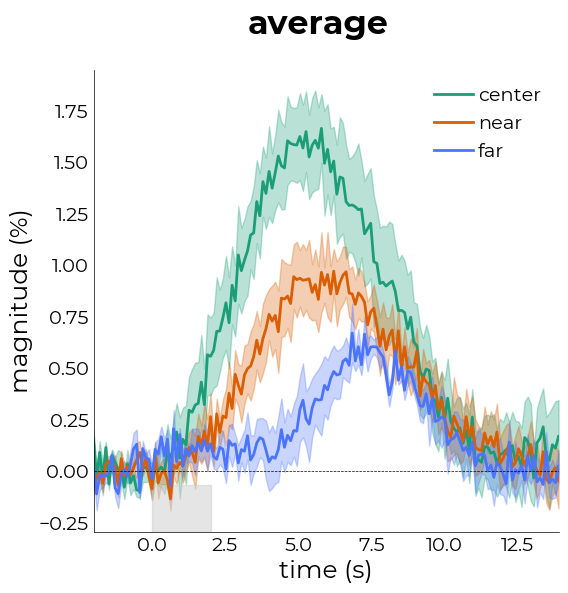

In [176]:
%matplotlib inline
avg_epoch = hr.viz.PlotEpochProfiles(
    avg_ev.groupby(["event_type","epoch","t"]).mean(),
    title="average",
    ev_names=["center","near","far"],
    cm=subj_obj.get_colors(),
    y_label="magnitude (%)"
)
 
# hr.viz._save_figure(avg_epoch.fig, fname="group_desc-epochs_average")

### Also check what happens if I shift baselines of within subjects before averaging across subjects

In [177]:
sub_avg_ep = sub_df.groupby(["subject","event_type","t"]).mean()
sub_avg_ep.head()

0
subject event_type t                  
001     act        -2.000000 -0.626285
                   -1.894737 -1.455889
                   -1.789474 -0.933864
                   -1.684211 -1.850079
                   -1.578947 -0.872159

In [178]:
n_subjs = utils.get_unique_ids(sub_avg_ep, id="subject")
evs = utils.get_unique_ids(sub_avg_ep, id="event_type")
df = []
for s in n_subjs:
    for e in evs:
        shift = fitting.Epoch.correct_baseline(
            utils.multiselect_from_df(
                sub_avg_ep, 
                expression=[
                    f"subject = {s}",
                    f"event_type = {e}"
                ]
            )
        )

        df.append(shift)

df_sub_shift = pd.concat(df)
df_sub_shift.head()

0
subject event_type t                  
001     act        -2.000000  0.589423
                   -1.894737 -0.240182
                   -1.789474  0.281843
                   -1.684211 -0.634372
                   -1.578947  0.343549

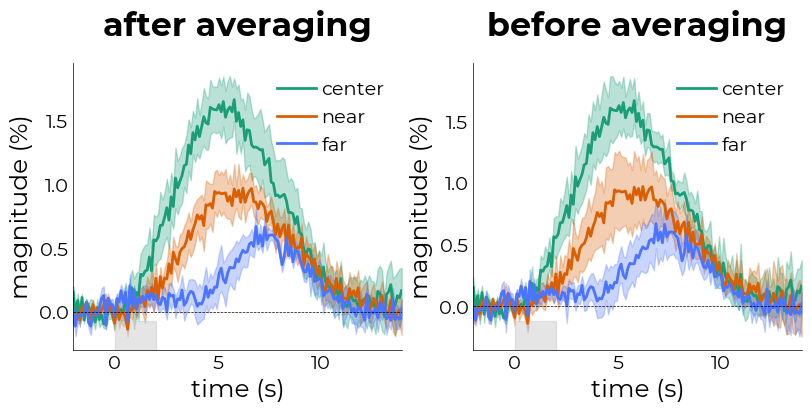

In [179]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4), constrained_layout=True)

%matplotlib inline
avg_epoch = hr.viz.PlotEpochProfiles(
    avg_ev.groupby(["event_type","epoch","t"]).mean(),
    title="after averaging",
    ev_names=["center","near","far"],
    cm=subj_obj.get_colors(),
    y_label="magnitude (%)",
    axs=ax1,
    force_title=True
)
 
# hr.viz._save_figure(avg_epoch.fig, fname="group_desc-epochs_average")

avg_epoch = hr.viz.PlotEpochProfiles(
    df_sub_shift,
    title="before averaging",
    ev_names=["center","near","far"],
    cm=subj_obj.get_colors(),
    y_label="magnitude (%)",
    correct=False,
    axs=ax2,
    force_title=True
)
 
# hr.viz._save_figure(avg_epoch.fig, fname="group_desc-epochs_average")

### subject-specific epochs

Plotting 001
Plotting 002
Plotting 005
Plotting 006
Plotting 010
Plotting 011
Plotting 013


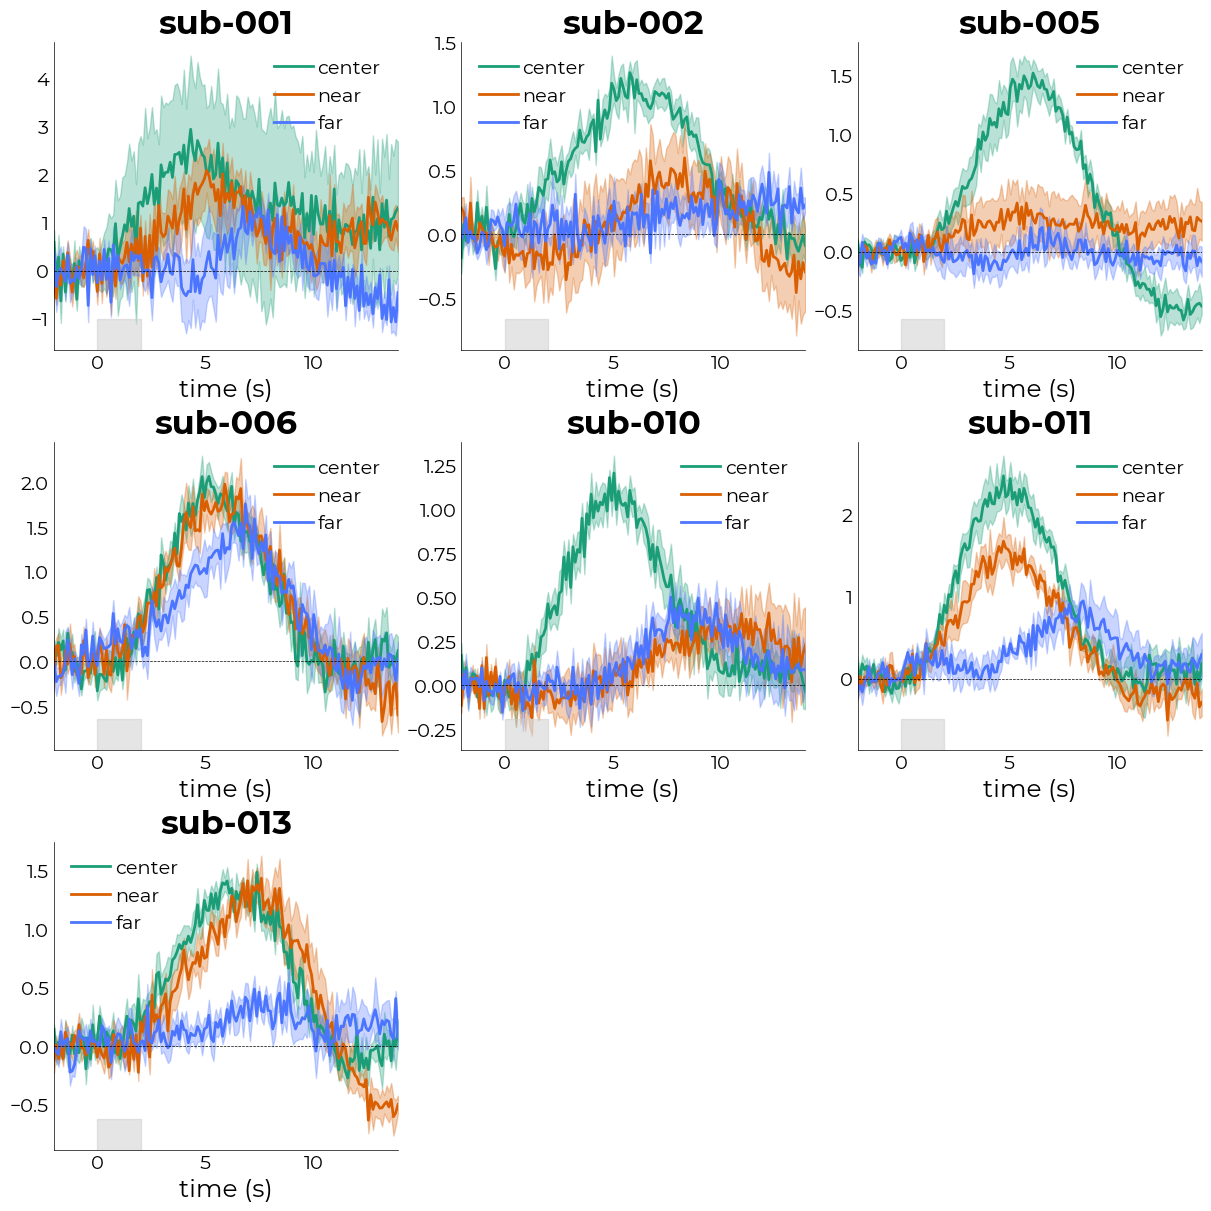

In [34]:
subj_ids = utils.get_unique_ids(sub_df, id="subject")
ncols = 3
nrows = int(np.ceil(len(subj_ids)/ncols))

fig,axs = plt.subplots(
    ncols=ncols, 
    nrows=nrows,
    figsize=(ncols*4,nrows*4), 
    constrained_layout=True
)

for ix,ax in enumerate(axs.flatten()):

    if (ix+1)>len(subj_ids):
        # remove obsolete axes
        ax.remove()
    else:
        sub = subj_ids[ix]
        print(f"Plotting {sub}")

        select_sub = utils.select_from_df(sub_df, expression=f"subject = {sub}")
        avg_epoch = hr.viz.PlotEpochProfiles(
            select_sub.groupby(["event_type","epoch","t"]).mean(),
            axs=ax,
            ev_names=["center","near","far"],
            cm=subj_obj.get_colors()
        )

        ax.set_title(f"sub-{sub}", fontsize=24, fontweight="bold")

# hr.viz._save_figure(fig, fname="group_desc-epochs_subjects") #, overwrite=True)

In [122]:
subj_ids = utils.get_unique_ids(sub_df, id="subject")
for sub in subj_ids:
    fig,axs = plt.subplots(figsize=(6,6))
    sesID = subj_obj.get_session(f"sub-{sub}")
    select_sub = utils.select_from_df(sub_df, expression=f"subject = {sub}")
    avg_epoch = hr.viz.PlotEpochProfiles(
        select_sub.groupby(["event_type","epoch","t"]).mean(),
        axs=axs,
        ev_names=["center","near","far"],
        cm=subj_obj.get_colors()
    )

    hr.viz._save_figure(fig, fname=f"sub-{sub}_ses-{sesID}_desc-epochs_ribbon_avg", subject=f"sub-{sub}")
    plt.close()

### Xin Yu plot averaged over subjects/epochs

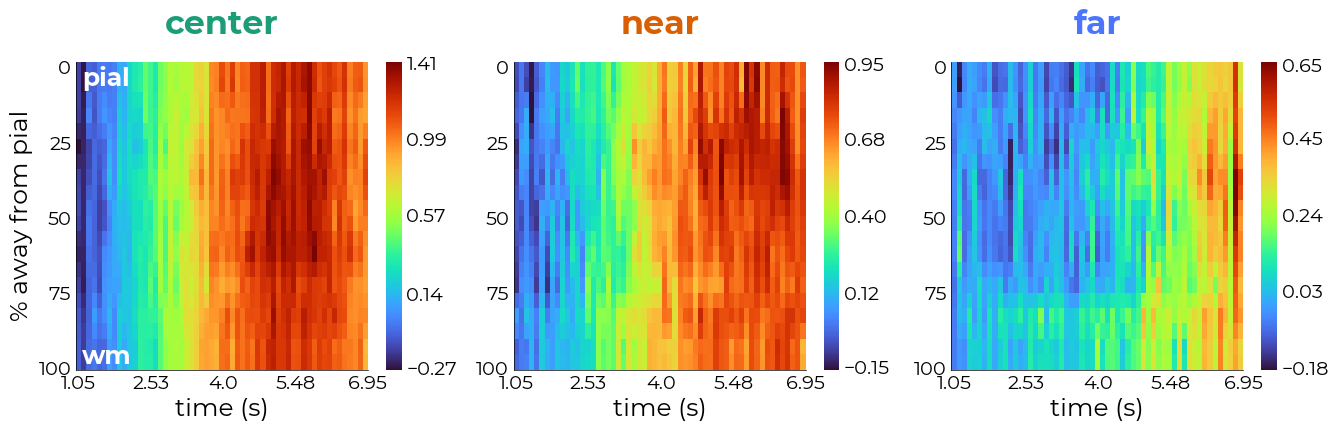

In [180]:
xy_avg = hr.viz.XinYuPlot(
    comp_avg_ev,
    show_time=[1,7],
    ev_names=subj_obj.get_evs(),
    ev_colors=subj_obj.get_colors(),
    cm="turbo",
    time_ticks=5,
    depth_ticks=5,
    cb_kws={
        "cm_decimal": 2
    },
)

# hr.viz._save_figure(xy_avg.fig, fname="group_desc-group_epochs_depth")

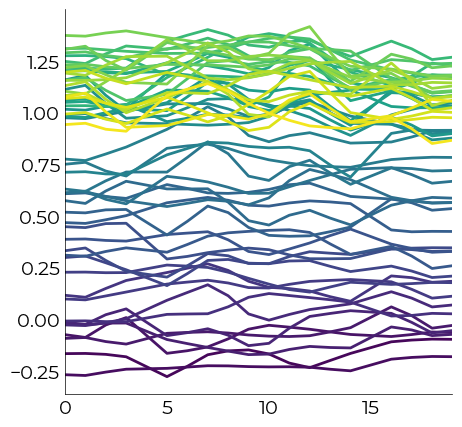

In [107]:
plotting.LazyPlot(
    [xy_avg.avg_imshow["center"].iloc[:,i].values for i in range(xy_avg.avg_imshow["center"].shape[-1])],    
    figsize=(5,5),
    line_width=2,
)

In [162]:
aic_df = []

order = [1,2,3,4]

for key,val in xy_avg.avg_imshow.items():

    ev_df = []
    for ord in order:

        aic = []
        for i in range(val.shape[1]):
            cf = fitting.CurveFitter(
                val.iloc[:,i].values,
                x=np.arange(0,data.shape[0]),
                order=ord,
                verbose=False
            )
            aic.append(cf.result.aic)

        ord_df = pd.DataFrame(aic, columns=["aic"])
        ord_df["order"] = ord
        ord_df["t"] = list(val.columns)

        ev_df.append(ord_df)

    ev_df = pd.concat(ev_df)
    ev_df["event_type"] = key
    aic_df.append(ev_df)
    
aic_df = pd.concat(aic_df)
aic_df.head()

aic  order     t event_type
0 -124.663130      1  1.05     center
1 -165.844652      1  1.16     center
2 -124.534261      1  1.26     center
3 -137.742388      1  1.37     center
4 -116.253382      1  1.47     center

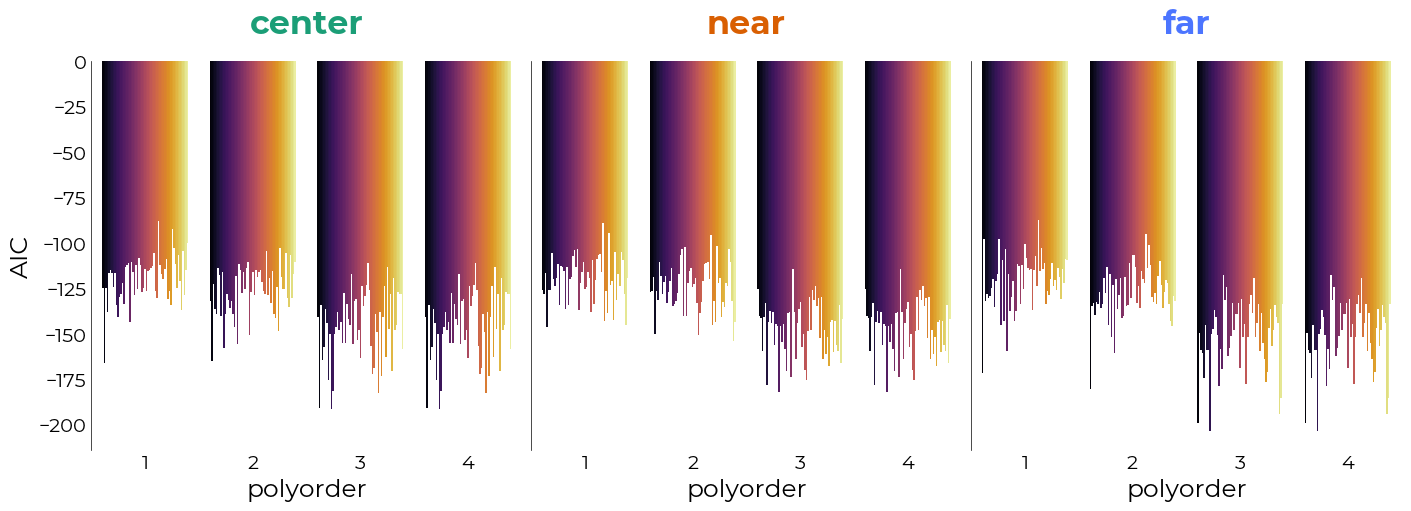

In [167]:
fig,axs = plt.subplots(ncols=len(xy_avg.avg_imshow), figsize=(14,5), sharey=True, constrained_layout=True)

for ix,(key,val) in enumerate(xy_avg.avg_imshow.items()):
    ev_df = utils.select_from_df(aic_df, expression=f"event_type = {key}")
    if ix == 0:
        y_lbl = "AIC"
    else:
        y_lbl = None

    plotting.LazyBar(
        ev_df,
        x="order",
        y="aic",
        hue="t",
        add_labels=True,
        x_label="polyorder",
        y_label=y_lbl,
        axs=axs[ix],
        title={
            "title": key,
            "fontweight": "bold",
            "color": subj_obj.get_colors()[ix]
        }
    )

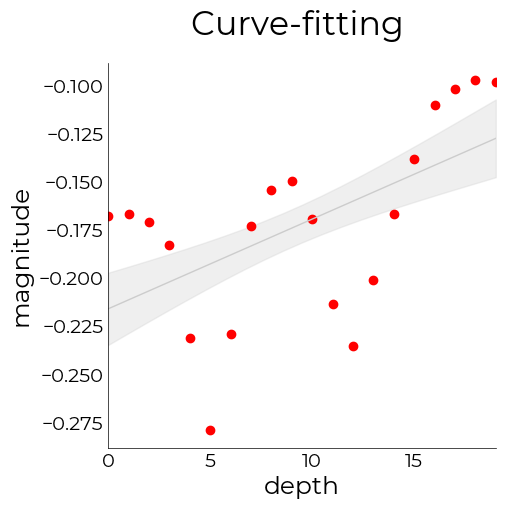

In [139]:
pl = plotting.LazyPlot(
    cf.y_pred_upsampled,
    xx=cf.x_pred_upsampled,
    error=cf.ci_upsampled,
    # axs=axs,
    color="#cccccc",
    x_label="depth",
    y_label="magnitude",
    figsize=(5,5),
    title="Curve-fitting ")

pl.axs.scatter(cf.x,cf.y_data, fc="r")
plt.show()

In [102]:
# import seaborn as sns
# import numpy as np
# from matplotlib import pyplot as plt
# from scipy import ndimage

# data_sq = hr.data.H5Parser.upsample2d(data.T, data.shape[-1])
# data_sq.columns = np.linspace(0, 100, data_sq.shape[-1])
# data_sq.head()

# flights = sns.load_dataset("flights")
# flights = flights.pivot("month", "year", "passengers")
# flights = data_sq.copy()
# fig, ax = plt.subplots()

# smooth_scale = 5
# z = ndimage.zoom(flights.to_numpy(), smooth_scale)
# cntr = ax.contour(
#     np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
#     np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
#     z, 
#     levels=(0.2,0.5), 
#     colors='black')
# ax = sns.heatmap(flights.T, cbar=True, ax=ax, cmap="turbo")

# plt.tight_layout()
# plt.show()

# # smooth_scale = 5
# # z = ndimage.zoom(flights.to_numpy(), smooth_scale)

# # cntr = ax.contourf(
# #     np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
# #     np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
# #     z, 
# #     # levels=np.arange(0, 100, 4), 
# #     cmap='inferno'
# # )

# # ax = sns.heatmap(flights, alpha=0, cbar=False, ax=ax)
# # plt.colorbar(cntr, ax=ax)

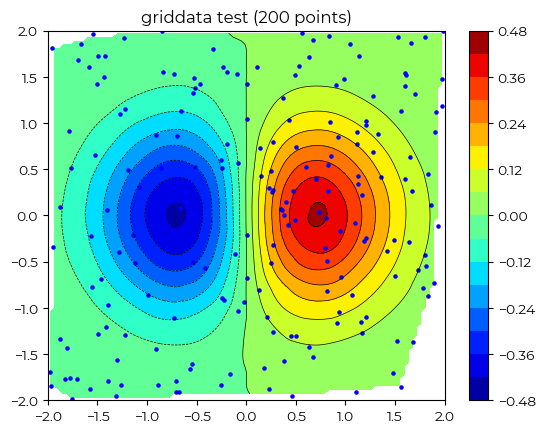

In [100]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
# make up some randomly distributed data
seed(1234)
npts = 200
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
z = x*np.exp(-x**2-y**2)
# define grid.
xi = np.linspace(-2.1,2.1,100)
yi = np.linspace(-2.1,2.1,100)
# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(x,y,marker='o',c='b',s=5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('griddata test (%d points)' % npts)
plt.show()


In [101]:
x

array([-1.2339222 ,  0.48843508, -0.24908904,  1.14143433,  1.11990323,
       -0.90962958, -0.89414298,  1.20748871,  1.83255741,  1.50373054,
       -0.56873092,  0.0039805 ,  0.73385174,  0.85080811, -0.51899698,
        0.24478474,  0.01233266, -1.9449262 ,  1.09130649,  1.53056476,
       -0.54045606,  0.46158471, -1.69847503, -0.52470398,  1.73256041,
        0.60551257, -0.41118969,  1.15492057, -0.73265551,  0.27239461,
        1.47650956, -0.2553063 ,  1.20859057, -1.4249327 ,  0.81704388,
        0.81832523, -1.12483158,  1.69947051, -0.23143698,  1.63726384,
       -1.76076311, -1.26285166, -1.81057888,  0.69952377,  0.37849912,
        0.13324065, -1.82670375,  0.24573232, -0.68132622,  0.01186733,
       -1.55242273,  0.42877482,  0.26377857, -1.97294375,  0.46976684,
        1.64849155,  1.16209653,  1.96832586,  1.83520705,  1.16785654,
       -0.85899616,  0.49966682, -0.08762482, -1.21729929, -0.47073019,
       -1.78450526, -0.19340637,  1.92801897, -1.5042292 , -1.52

In [92]:
z.shape

(285, 285)

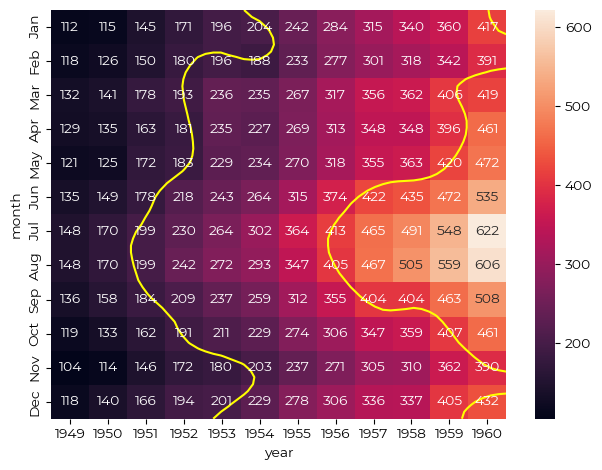

In [77]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
fig, ax = plt.subplots()

smooth_scale = 5
z = ndimage.zoom(flights.to_numpy(), smooth_scale)
cntr = ax.contour(np.linspace(0, len(flights.columns), len(flights.columns) * smooth_scale),
                  np.linspace(0, len(flights.index), len(flights.index) * smooth_scale),
                  z, levels=(200, 400), colors='yellow')
ax = sns.heatmap(flights, annot=True, fmt='d', cbar=True, ax=ax)

plt.tight_layout()
plt.show()

In [78]:
flights.columns

Int64Index([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
            1960],
           dtype='int64', name='year')

In [22]:
x.shape,y.shape

((240,), (160,))

profiles @:
- center 5s
- near 6s
- far 7s


# max val over depth > normalize? 
np.max(<some_data>, axis=1)

In [48]:
profiles_at_tpoint = [5,6,7]

evs = utils.get_unique_ids(comp_avg_ev, id="event_type")
resp = []
se = []
for ix,(ev,n_ev,t_) in enumerate(zip(evs,subj_obj.get_evs(),profiles_at_tpoint)):

    t_points = utils.get_unique_ids(comp_avg_ev, id="t")
    t_closest = utils.find_nearest(t_points, t_)[-1]

    ev_df = utils.multiselect_from_df(
        comp_avg_ev, 
        expression=[
            f"event_type = {ev}",
            f"t = {t_closest}"
        ]
    )

    grouper = ev_df.groupby(["event_type","t"])
    resp.append(grouper.mean().values.squeeze())
    se.append(grouper.sem().values.squeeze())

In [81]:
list(np.arange(0,120, step=25))

[0, 25, 50, 75, 100]

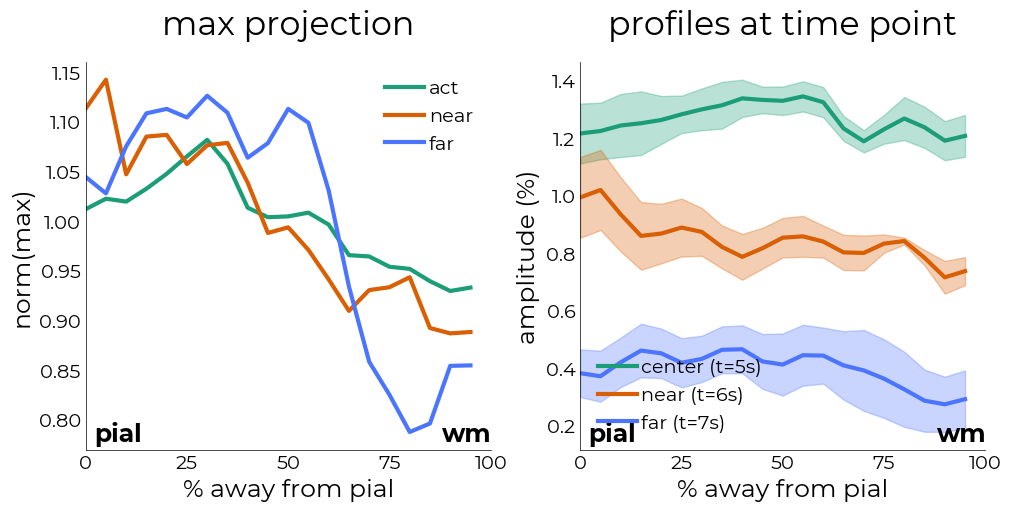

In [99]:
fig,(ax1,ax2) = plt.subplots(
    ncols=2, 
    figsize=(10,5), 
    constrained_layout=True
)

#------------------------------------------------------------------------------------------------------------------------------
# MAXIMUM PROJECTION
for ix,(key,val) in enumerate(xy_avg.avg_imshow.items()):
    max_vals = val.max(axis=1).values
    x_obj = hr.viz.make_wm_pial_ticks(max_vals)
    pl = plotting.LazyPlot(
        max_vals/max_vals.mean(),
        axs=ax1,
        line_width=3,
        color=subj_obj.get_colors()[ix],
        labels=[["act","near","far"][ix]],
        title="max projection",
        x_label="% away from pial",
        y_label="norm(max)",
        x_ticks=x_obj["ticks"],
        x_ticklabels=x_obj["labels"]
    )

hr.viz.annotate_cortical_ribbon(
    axs=ax1,
    pial_pos=(0.02,0.02),
    wm_pos=(0.88,0.02),
    fontsize=pl.font_size,
    fontweight="bold"
)

#------------------------------------------------------------------------------------------------------------------------------
# MAXIMUM AT TIMEPOINT
x_obj = hr.viz.make_wm_pial_ticks(resp[0])
obj = plotting.LazyPlot(
    resp,
    axs=ax2,
    labels=[f"{ev} (t={profiles_at_tpoint[ix]}s)" for ix,ev in enumerate(subj_obj.get_evs())],
    color=subj_obj.get_colors(),
    line_width=3,
    error=se,
    x_label="% away from pial",
    y_label="amplitude (%)",
    title="profiles at time point",
    x_ticks=x_obj["ticks"],
    x_ticklabels=x_obj["labels"]
)

hr.viz.annotate_cortical_ribbon(
    axs=ax2,
    fontsize=obj.font_size,
    fontweight="bold",
    pial_pos=(0.02,0.02),
    wm_pos=(0.88,0.02)
)

hr.viz._save_figure(fig, fname="group_desc-maximum_projection")

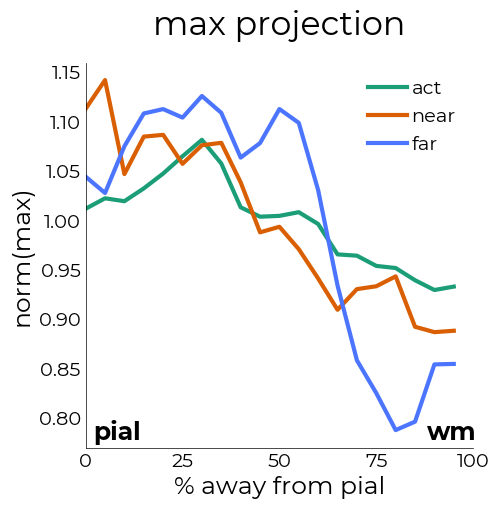

In [96]:
fig,axs = plt.subplots(figsize=(5,5))
for ix,(key,val) in enumerate(xy_avg.avg_imshow.items()):
    max_vals = val.max(axis=1).values
    x_obj = hr.viz.make_wm_pial_ticks(max_vals)
    pl = plotting.LazyPlot(
        max_vals/max_vals.mean(),
        axs=axs,
        line_width=3,
        color=subj_obj.get_colors()[ix],
        labels=[["act","near","far"][ix]],
        title="max projection",
        x_label="% away from pial",
        y_label="norm(max)",
        x_ticks=x_obj["ticks"],
        x_ticklabels=x_obj["labels"]
    )

hr.viz.annotate_cortical_ribbon(
    axs=axs,
    pial_pos=(0.02,0.02),
    wm_pos=(0.88,0.02),
    fontsize=pl.font_size,
    fontweight="bold"
)
hr.viz._save_figure(fig, fname="group_desc-maximum_projection")

In [164]:
max_vals.shape

(57,)

In [129]:
utils.multiselect_from_df(
    comp_avg_ev.groupby(["event_type","t"]).mean(), 
    expression=[
        f"event_type = {ev}",
        "t gt 1",
        "t lt 7"
    ]
).head(5)

0         1         2         3         4
event_type t                                                         
suppr_2    1.052632 -0.033283 -0.163129 -0.022641 -0.078635 -0.084283
           1.157895 -0.065433 -0.025680  0.100609 -0.012339 -0.005376
           1.263158 -0.029317 -0.054130 -0.075674 -0.046182 -0.034415
           1.368421 -0.041546 -0.071086 -0.020068 -0.010917 -0.006827
           1.473684 -0.032198 -0.031927  0.020976 -0.065706 -0.032305

(<Axes: xlabel='time (s)'>, <linescanning.plotting.Defaults at 0x7f1ee9aaf220>)

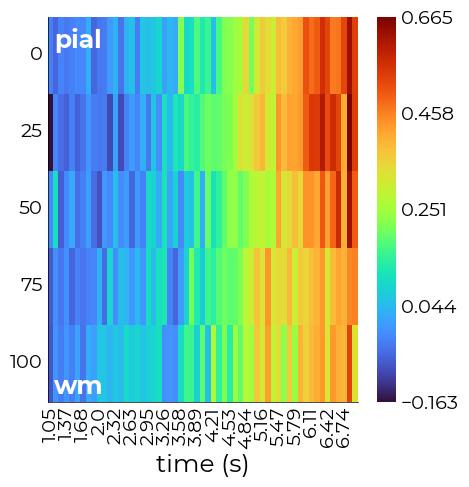

In [137]:
in_data = utils.multiselect_from_df(
    comp_avg_ev.groupby(["event_type","t"]).mean(), 
    expression=[
        f"event_type = {ev}",
        "t gt 1",
        "t lt 7"
    ]
)

hr.viz.XinYuPlot.single_xinyu_plot(
    in_data,
    cb_kws={
        "cm_decimals": 2
    }
)

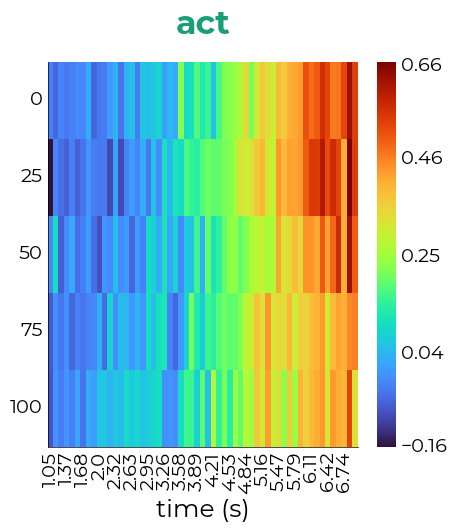

In [122]:
fig,axs = plt.subplots(figsize=(5,5))

try:
    df.set_index([new_t], inplace=True)
except:
    pass

heat = sns.heatmap(
    df.T,
    cmap="turbo",
    ax=axs,
)

axs.set_yticks(axs.get_yticks(), rotation=0, labels=axs.get_yticklabels())
_ = plotting.conform_ax_to_obj(
    ax=axs,
    title={
        "title": ["act","near","far"][0],
        "fontweight": "bold",
        "color": subj_obj.get_colors()[0]
    },
    
)

cbar = axs.collections[0].colorbar.ax
plotting.LazyColorbar(
    cmap="turbo",
    axs=cbar,
    vmin=df.min().min(),
    vmax=df.max().max(),
    cm_decimal=2
)

0 152
(5, 152)
456 1368
(5, 0)


ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (3).

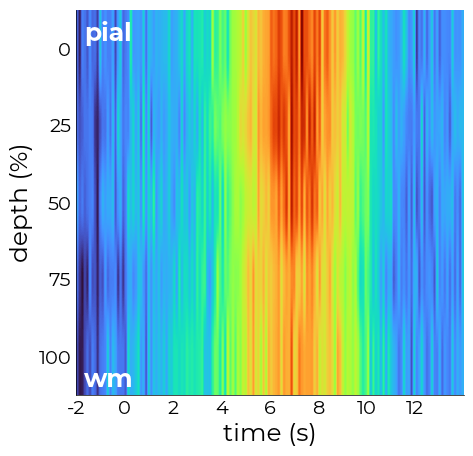

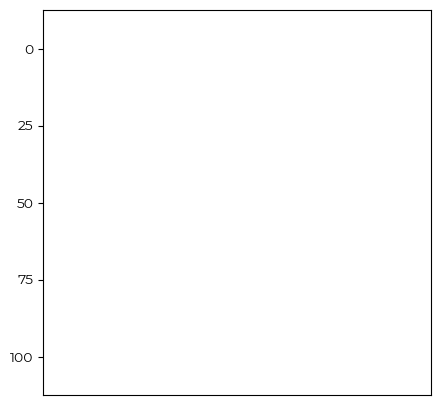

In [150]:
in_data = xy_avg.avg_imshow[nn]
ax,xy = hr.viz.XinYuPlot.single_xinyu_plot(
    in_data,
    force_int=True,
    cm="turbo"
)

in_data = xy_avg.avg_imshow[nn]
ax,xy = hr.viz.XinYuPlot.single_xinyu_plot(
    in_data,
    force_int=True,
    cm="turbo",
    show_time=[1,7]
)

In [381]:
# hr.viz.BijanzadehFigures.plot_single_bijanzadeh(
#         subj_obj.bijanzadeh_figures["center"]
#     )

In [223]:
subj_obj.bijanzadeh_figures

{'center': '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/Fig3a_bijanzadeh_2018.pdf',
 'near': '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/Fig3c_bijanzadeh_2018.pdf',
 'far': '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/Fig3d_bijanzadeh_2018.pdf'}

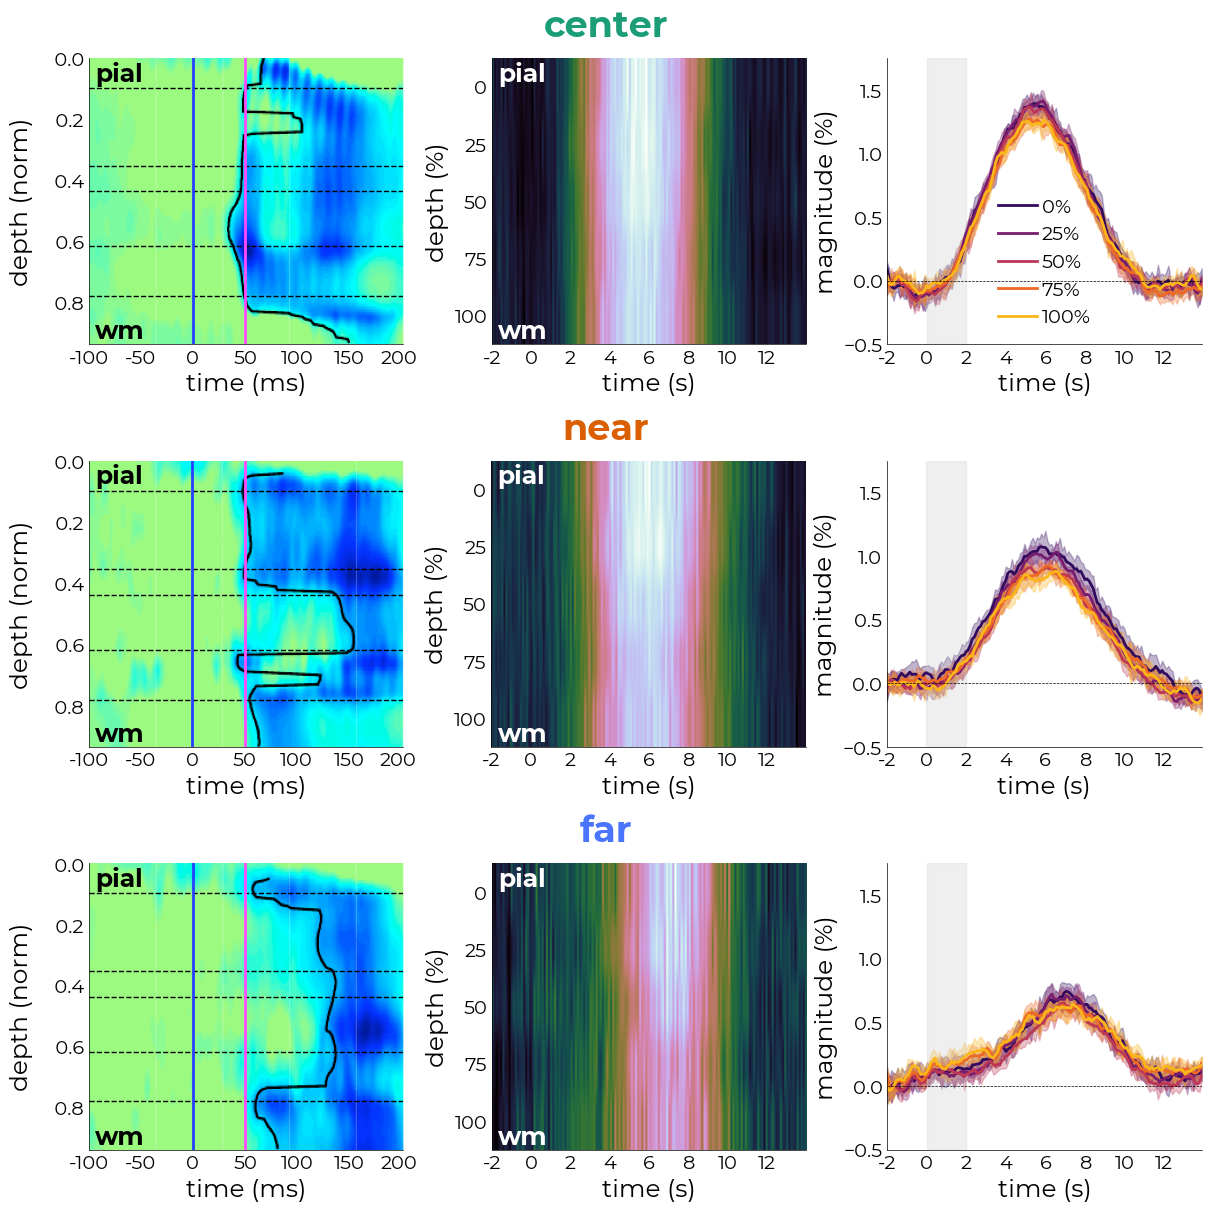

In [22]:
evs = utils.get_unique_ids(comp_avg_ev, id="event_type")
fig = plt.figure(figsize=(12,12), constrained_layout=True)
sf = fig.subfigures(nrows=len(evs))

y_lim = [-0.5,1.75]
for ix,(ev,nn) in enumerate(zip(evs,["center","near","far"])):

    in_data = xy_avg.avg_imshow[nn]
    sem_data = list(utils.select_from_df(comp_avg_ev, expression=f"event_type = {ev}").groupby(["t"]).sem().values.T)
    axs = sf[ix].subplots(ncols=3)

    # plot Bijanzadeh fiures
    ax1 = axs[0]
    b_ = hr.viz.BijanzadehFigures.plot_single_bijanzadeh(
        subj_obj.bijanzadeh_figures[nn],
        axs=ax1,
        x_label="time (ms)",
        y_label="depth (norm)"
    )

    # fMRI 
    ax2 = axs[1]
    ax,xy = hr.viz.XinYuPlot.single_xinyu_plot(
        in_data,
        axs=ax2,
        force_int=True
    )
    
    # Profiles
    ax3 = axs[2]
    if ix == 0:
        add_lbl = [f"{int(i)}%" for i in np.linspace(0,100,in_data.shape[0])]
    else:
        add_lbl = None
        
    t_ = utils.get_unique_ids(comp_avg_ev, id="t")
    corr_list = [
        preproc.lowpass_savgol(
            hr.utils.correct_baseline(
                i, 
                bsl=5
            ), 
            window_length=9, 
            polyorder=3
        ) for i in list(in_data)
    ]
    pl = plotting.LazyPlot(
        corr_list,
        xx=t_,
        x_ticks=ax.get_xticklabels(),
        x_ticklabels=ax.get_xticklabels(),
        axs=ax3,
        cmap="inferno",
        labels=add_lbl,
        add_hline=0,
        x_label="time (s)",
        y_label="magnitude (%)",
        line_width=2,
        y_lim=y_lim,
        error=sem_data
    )

    hr.viz.add_axvspan(ax3)

    sf[ix].suptitle(
        nn, 
        color=subj_obj.get_colors()[ix],
        fontsize=pl.title_size*1.1, 
        fontweight="bold"
    )

# # save
# hr.viz._save_figure(fig, fname="group_desc-depth_imshow_profiles")

In [174]:
# diff_cent_far = xy_avg.avg_imshow["center"]-xy_avg.avg_imshow["far"]
# fig,axs = plt.subplots(ncols=2, figsize=(9,4), constrained_layout=True)
# hr.viz.XinYuPlot.single_xinyu_plot(
#     diff_cent_far,
#     axs=axs[0],
#     force_int=True
# )

# t_ = utils.get_unique_ids(comp_avg_ev, id="t")[:400]
# pl = plotting.LazyPlot(
#     [preproc.lowpass_savgol(i, window_length=9, polyorder=3) for i in list(diff_cent_far)],
#     xx=t_,
#     axs=axs[1],
#     cmap="inferno",
#     labels=[f"{int(i)}%" for i in np.linspace(0,100,diff_cent_far.shape[0])],
#     add_hline=0,
#     x_label="time (s)",
#     y_label="magnitude (%)",
#     line_width=2
# )

# fig.suptitle("center-far", fontweight="bold", fontsize=pl.title_size*1.2)
# hr.viz._save_figure(fig, fname="group_desc-depth_imshow_center_min_far")

## Deconvolve

### Three compartment model

In [39]:
ff = hr.data.make_single_df(h5_obj.df_comps)
oo = hr.data.make_single_df(h5_obj.df_onsets, idx=["subject","run","event_type"])

comp_fit = fitting.NideconvFitter(
    ff,
    oo,
    basis_sets='canonical_hrf_with_time_derivative_dispersion',
    # basis_sets="fir",
    # n_regressors="tr",
    # basis_sets="fourier",
    # n_regressors=4,
    TR=0.105,
    interval=[-2,26],
    verbose=True,
    conf_intercept=True,
)

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done


|████████████████████████████████████████| 5/5 [100%] in 0.4s (13.07/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (13.61/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.4s (12.87/s)         


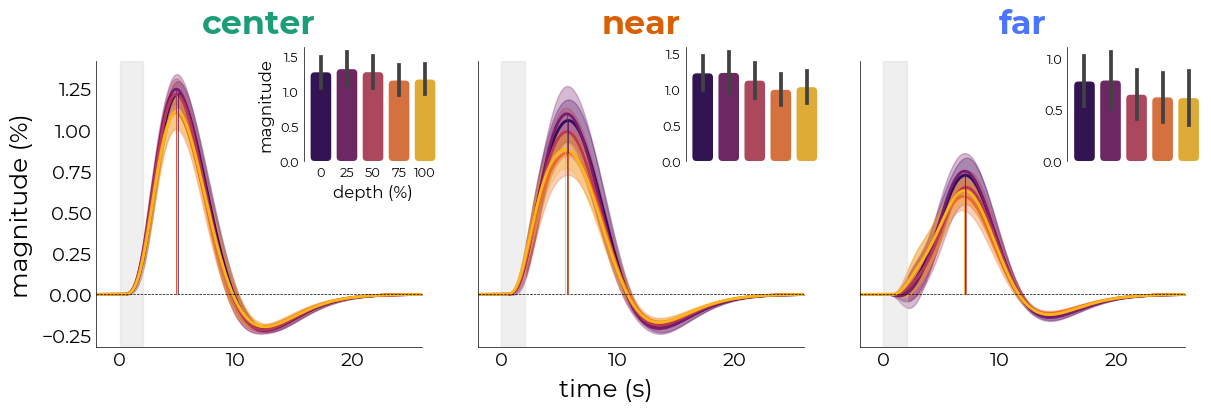

In [338]:
dec_comp = hr.viz.PlotDeconvProfiles(
    comp_fit,
    inset_kwargs={
        "fancy": True,
        # "fancy_denom": 3,
        "sns_offset": 3,
        # "add_points": True,
        "sns_ori": "v"
    },
    ev_names=["center","near","far"],
    ev_colors=subj_obj.get_colors(),
    bold_title=True,
    err="sem",
    inset_par="magnitude",
    force_int=True
)

# hr.viz._save_figure(dec_comp.fig, fname="group_desc-depth_deconv")

In [339]:
# create dataframe of stimulus sizes
stim_df = subj_obj.create_stim_df()
stim_df.head()

stim_size
subject event_type           
001     act              1.64
        suppr_1          3.57
        suppr_2          5.10
002     act              2.64
        suppr_1          4.47

In [340]:
# add these to the parameter dataframe
merge_pars = h5_obj.merge_pars_stim_values(comp_fit.pars_subjects.groupby(["subject","event_type","vox"]).mean(), stim_df)
merge_pars

magnitude  magnitude_ix      fwhm  time_to_peak  \
subject event_type vox                                                    
001     act        0     1.313307      1286.000  4.463772      4.751500   
                   1     1.424270      1162.000  4.278029      4.100500   
                   2     1.323069      1123.000  4.287038      3.895750   
                   3     0.966695      1146.000  4.289779      4.016500   
                   4     0.970439      1268.000  4.372160      4.657000   
...                           ...           ...       ...           ...   
011     suppr_2    0     0.444827      1684.250  4.250665      6.842313   
                   1     0.434051      1689.500  4.213692      6.869875   
                   2     0.339338      1620.500  3.989318      6.507625   
                   3     0.384954      1626.875  3.970570      6.541094   
                   4     0.419736      1398.625  4.632599      5.342781   

                        half_rise_time  half_max  rise_slope  rise_slope_t  \
subject event_type vox                                                       
001     act        0          2.744746  0.656653    0.543092      2.735500   
                   1          2.276568  0.712135    0.676290      2.221000   
                   2          2.159245  0.661534    0.667968      2.105500   
                   3          2.224166  0.483347    0.470987      2.168500   
                   4          2.686541  0.485219    0.407208      2.677750   
...                                ...       ...         ...           ...   
011     suppr_2    0          4.951230  0.222414    0.217535      4.536250   
                   1          4.986696  0.217025    0.222563      4.655688   
                   2          4.721776  0.169669    0.129600      4.336094   
                   3          4.306160  0.192477    0.170953      3.941031   
                   4          3.724488  0.209868    0.228904      3.568938   

                        positive_area  undershoot  stim_size  
subject event_type vox                                        
001     act        0         5.890937    1.379070       1.64  
                   1         6.128609    1.408884       1.64  
                   2         5.749360    1.213300       1.64  
                   3         4.181513    0.927713       1.64  
                   4         4.263630    1.025235       1.64  
...                               ...         ...        ...  
011     suppr_2    0         2.146539    0.722276       9.92  
                   1         2.198069    0.764682       9.92  
                   2         1.876729    0.913841       9.92  
                   3         2.097532    0.621075       9.92  
                   4         2.091165    0.591799       9.92  

[90 rows x 11 columns]

In [1]:
# correlate across depth
ev_ids = utils.get_unique_ids(merge_pars, id="event_type")
figsize = (len(ev_ids)*5,4)

fig,axs = plt.subplots(ncols=len(ev_ids), figsize=figsize)

for ix,ev in enumerate(ev_ids):
    ax = axs[ix]
    
    merge_avg = utils.select_from_df(merge_pars, expression=f"event_type = {ev}").groupby(["subject","event_type"]).mean()
    plotting.LazyCorr(
        data=merge_avg,
        x="magnitude",
        y="stim_size",
        color_by="subject",
        axs=ax,
        x_label="magnitude",
        y_label="stimulus size",
        correlation=True,
        result_to_plot=True,
        result_loc=[0.3,0.1],
        scatter_kwargs={
            "cbar": False
        },
        title={
            "title": ["center","near","far"][ix],
            "fontweight": "bold",
            "color": subj_obj.get_colors()[ix]
        },
    )

# hr.viz._save_figure(fig, fname="group_desc-correlation_stimulus_response")

NameError: name 'utils' is not defined

In [96]:
merge_avg["sub_id"] = np.arange(0,len(utils.get_unique_ids(merge_avg, id="subject")))
merge_avg

magnitude  magnitude_ix      fwhm  time_to_peak  \
subject event_type                                                    
001     act          1.199556   1197.000000  4.338156      4.284250   
002     act          1.019032   1518.971429  5.641158      5.974600   
003     act          0.561527   1339.240000  4.515814      5.031010   
006     act          1.720849   1361.950000  4.200248      5.150238   
010     act          0.918181   1311.514286  4.876797      4.885450   
011     act          2.044693   1245.425000  4.339554      4.538481   

                    half_rise_time  half_max  rise_slope  rise_slope_t  \
subject event_type                                                       
001     act               2.418253  0.599778    0.553109      2.381650   
002     act               3.170959  0.509516    0.321973      2.893750   
003     act               3.122490  0.280763    0.284728      2.977420   
006     act               3.252990  0.860424    0.789464      3.176106   
010     act               2.732196  0.459091    0.376572      2.660200   
011     act               2.657926  1.022347    0.947516      2.610944   

                    positive_area  undershoot  stim_size  sub_id  
subject event_type                                                
001     act              5.242810    1.190840       1.64       0  
002     act              5.710232    1.142481       2.64       1  
003     act              2.442978    0.674942       1.89       2  
006     act              7.260258    2.024748       3.40       3  
010     act              4.413180    0.979406       1.76       4  
011     act              8.938517    2.290110       1.76       5

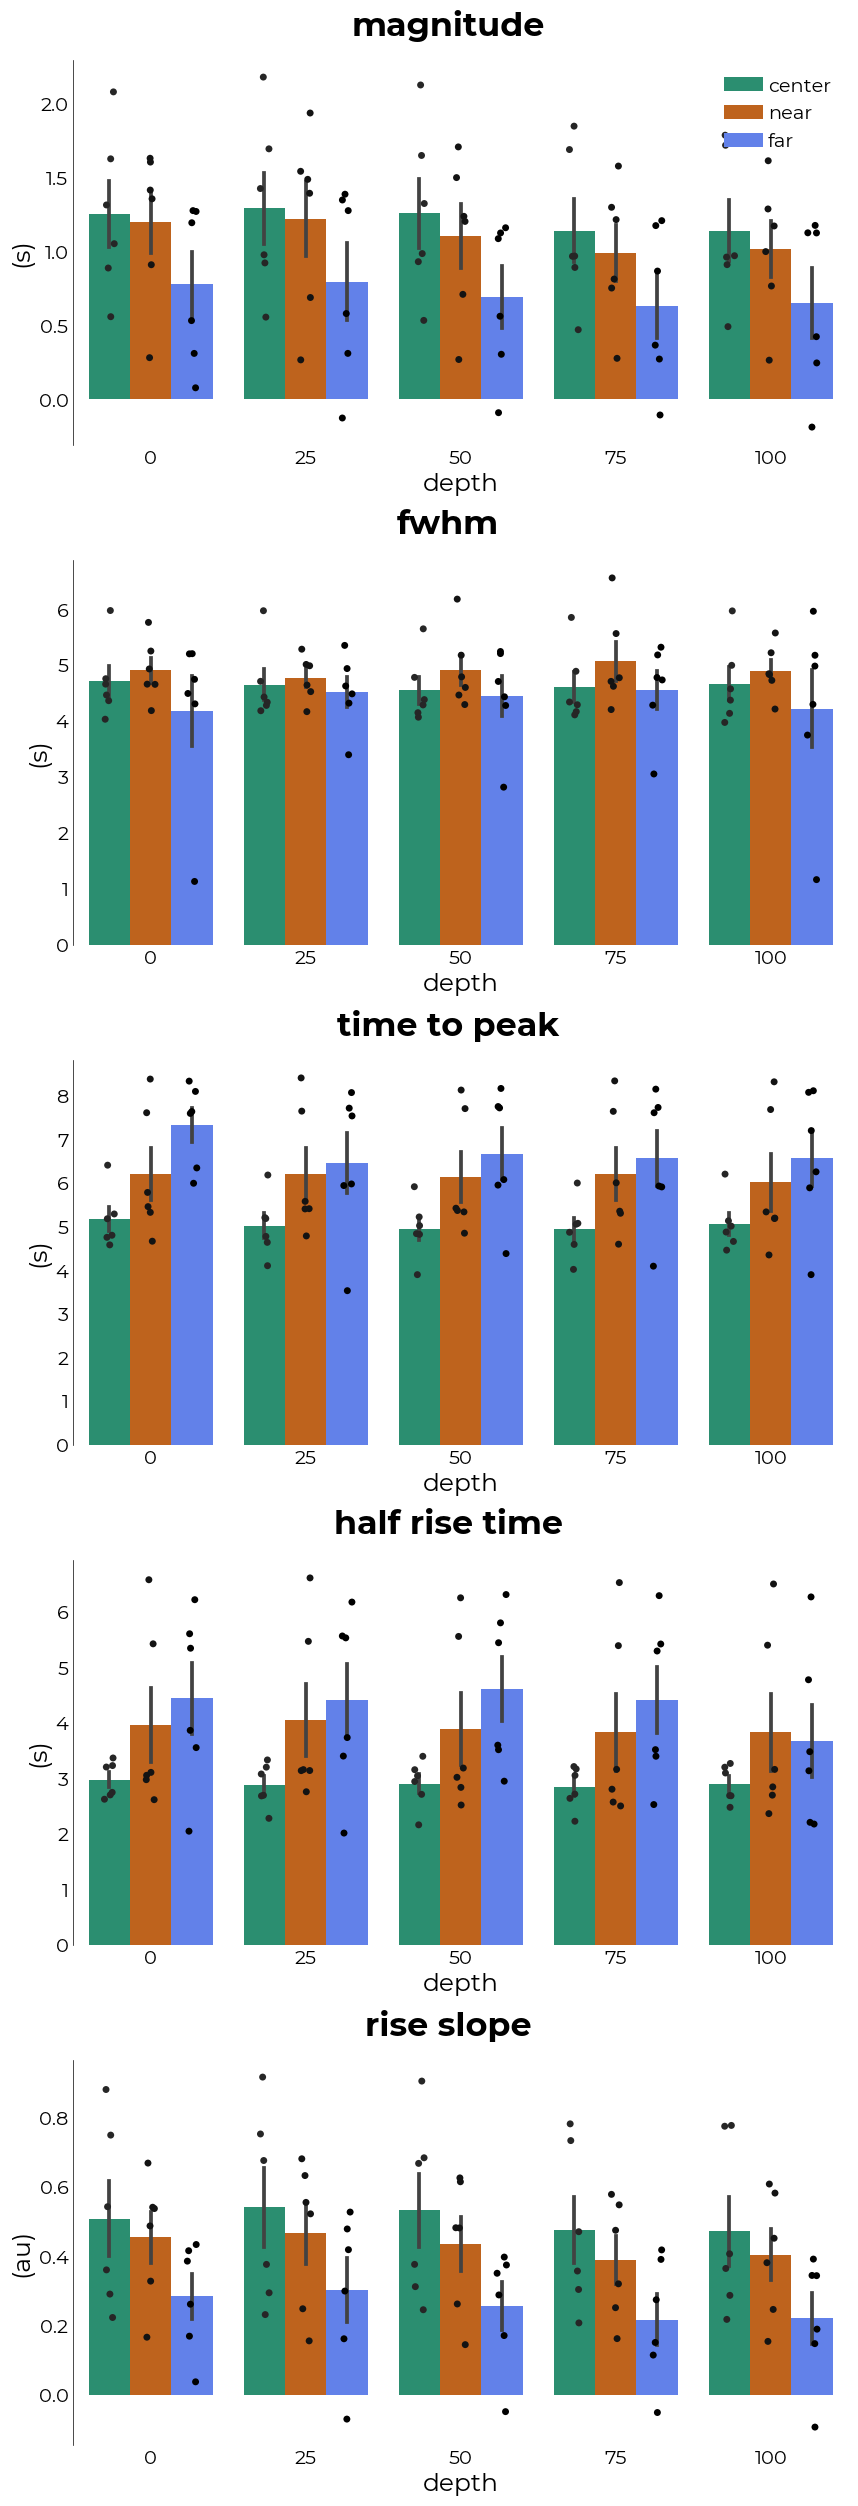

In [ ]:
incl_pars = {
    "magnitude": "s",
    "fwhm": "s",
    "time_to_peak": "s",
    "half_rise_time": "s",
    "rise_slope": "au"
}

fig = plt.figure(figsize=(10,len(incl_pars)*5))
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):
    if ix == 0:
        add_lgnd = True
    else:
        add_lgnd = False

    axs = sf[ix].subplots()
    bar_plot = plotting.LazyBar(
        data=comp_fit.avg_pars_subjects,
        x="vox",
        y=par,
        add_labels=True,
        labels=[int(i) for i in np.linspace(0,100, len(utils.get_unique_ids(comp_fit.avg_pars_subjects, id="vox")))],
        axs=axs,
        x_label="depth",
        y_label=f"({unit})",
        # fancy=True,
        # sns_offset=3,
        add_points=True,
        points_color="k",
        hue="event_type",
        lbl_legend=["center","near","far"],
        bar_legend=add_lgnd,
        cmap=subj_obj.get_colors()
    ) 

    sf[ix].suptitle(par.replace("_"," "), fontsize=bar_plot.title_size, fontweight="bold")

hr.viz._save_figure(fig, fname="group_desc-parameters_ev")

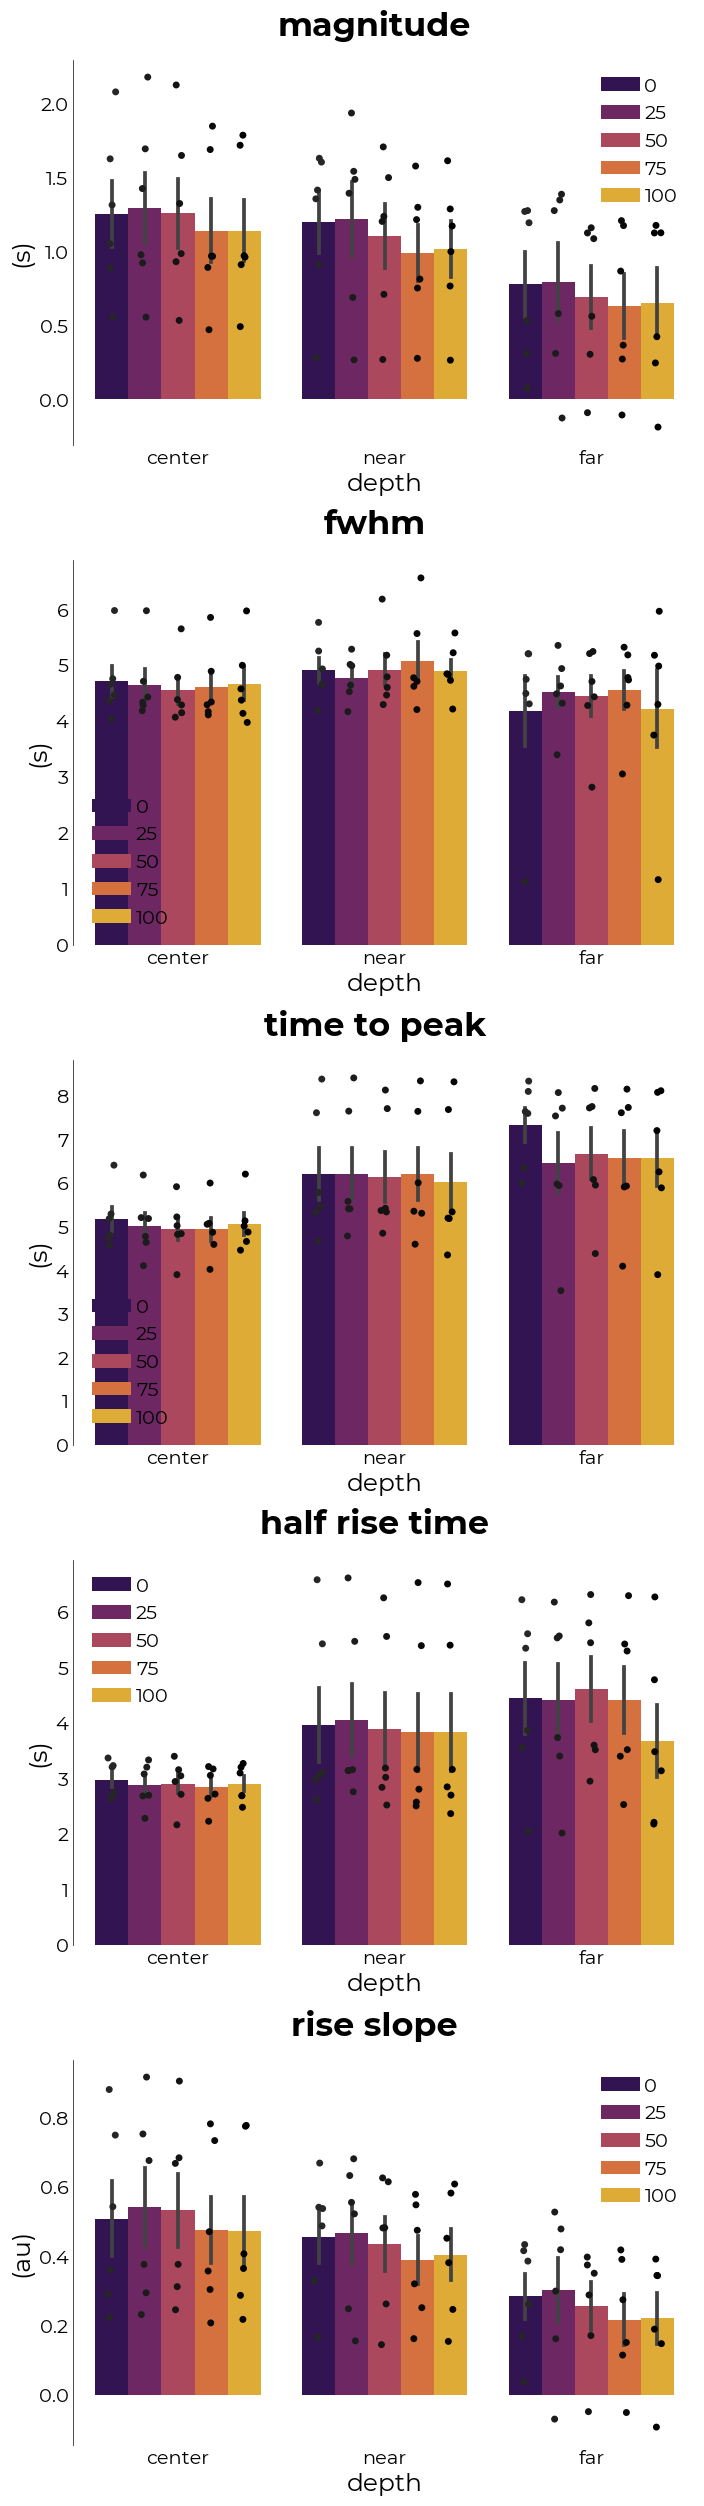

In [ ]:
incl_pars = {
    "magnitude": "s",
    "fwhm": "s",
    "time_to_peak": "s",
    "half_rise_time": "s",
    "rise_slope": "au"
}

fig = plt.figure(figsize=(8,len(incl_pars)*5))
sf = fig.subfigures(nrows=len(incl_pars))
for ix,(par,unit) in enumerate(incl_pars.items()):
    axs = sf[ix].subplots()
    bar_plot = plotting.LazyBar(
        data=comp_fit.avg_pars_subjects,
        x="event_type",
        y=par,
        add_labels=True,
        labels=["center","near","far"],
        axs=axs,
        x_label="depth",
        y_label=f"({unit})",
        # fancy=True,
        sns_offset=1,
        add_points=True,
        points_color="k",
        hue="vox",
        lbl_legend=[int(i) for i in np.linspace(0,100, len(utils.get_unique_ids(comp_fit.avg_pars_subjects, id="vox")))],
        bar_legend=True,
    ) 

    sf[ix].suptitle(par.replace("_"," "), fontsize=bar_plot.title_size, fontweight="bold")

hr.viz._save_figure(fig, fname="group_desc-parameters_depth")

In [ ]:
# fig,axs = plt.subplots(figsize=(10,6), constrained_layout=True)
# bar_plot = plotting.LazyBar(
#     data=comp_fit.avg_pars_subjects,
#     x="vox",
#     y="magnitude",
#     add_labels=True,
#     labels=[int(i) for i in np.linspace(0,100, len(utils.get_unique_ids(comp_fit.avg_pars_subjects, id="vox")))],
#     axs=axs,
#     x_label="depth",
#     y_label="(s)",
#     title={"title": "half rise time", "fontweight": "bold"},
#     # fancy=True,
#     # sns_offset=3,
#     hue="event_type",
#     lbl_legend=["center","near","far"],
#     bar_legend=True
# ) 

### Deconvolution vs Epoching

In [128]:
comp_fit.tc_subjects.groupby(["subject","event_type"]).mean()

0         1         2         3         4
subject event_type                                                  
001     act         0.161542  0.168984  0.162408  0.116498  0.115947
        suppr_1     0.200608  0.209510  0.209833  0.149647  0.157155
        suppr_2     0.181393  0.193067  0.171560  0.133040  0.163471
002     act         0.176519  0.163779  0.156850  0.159401  0.161077
        suppr_1     0.124257  0.094895  0.097303  0.111253  0.119424
        suppr_2     0.012413 -0.010231  0.000085 -0.001642 -0.017291
003     act         0.072510  0.067762  0.057425  0.051581  0.054409
        suppr_1     0.195874  0.195232  0.165742  0.162181  0.159085
        suppr_2     0.185851  0.192537  0.169835  0.176117  0.163711
006     act         0.172470  0.190348  0.198126  0.188938  0.177916
        suppr_1     0.264408  0.288244  0.248860  0.247452  0.237366
        suppr_2     0.186553  0.190088  0.165987  0.175970  0.196773
010     act         0.118187  0.121344  0.124598  0.122477  0.128104
        suppr_1     0.023152  0.023920  0.023777  0.022413  0.021264
        suppr_2     0.025997  0.028860  0.024374  0.022389  0.015482
011     act         0.247442  0.256857  0.235084  0.218082  0.227738
        suppr_1     0.208269  0.192936  0.184363  0.167172  0.176282
        suppr_2     0.051397  0.052667  0.050403  0.059860  0.072879

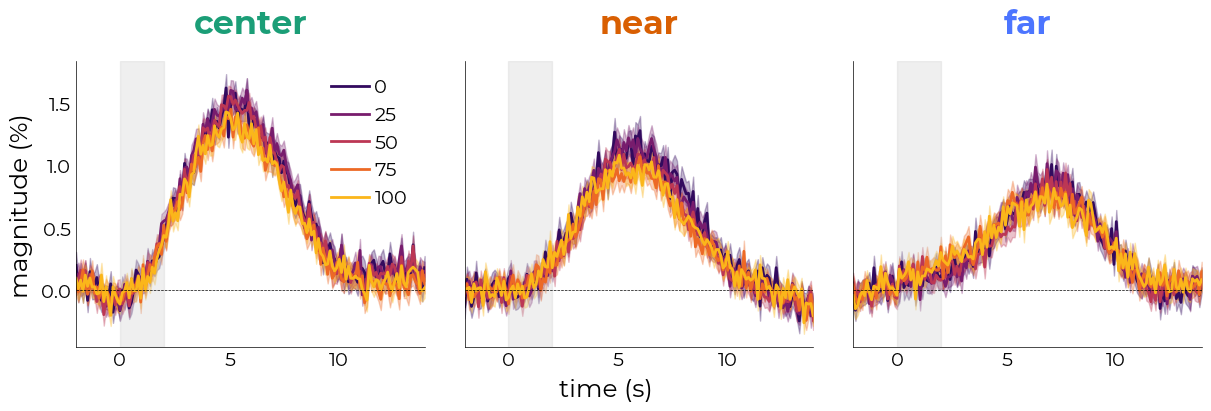

In [184]:
ep_comp = hr.viz.PlotDeconvProfiles(
    comp_df,
    inset_kwargs={
        "fancy": True,
        # "fancy_denom": 3,
        "sns_offset": 3,
        # "add_points": True,
        "sns_ori": "v"
    },
    ev_names=["center","near","far"],
    ev_colors=subj_obj.get_colors(),
    bold_title=True,
    err="sem",
    time_par="t",
    force_int=True,
    bsl=20
)

hr.viz._save_figure(ep_comp.fig, fname="group_desc-depth_epoch")

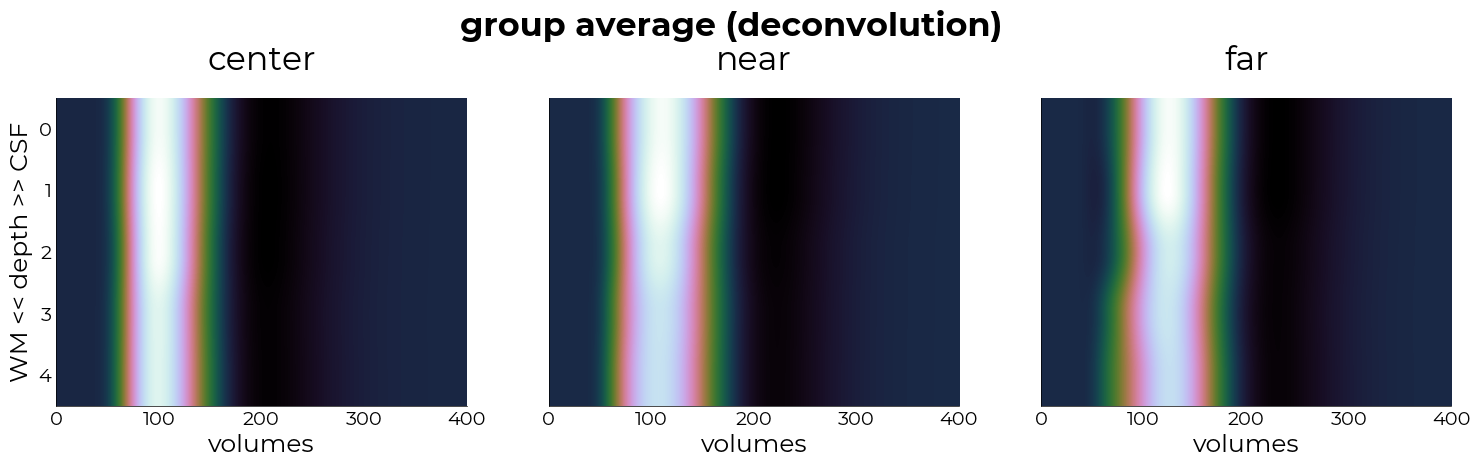

In [ ]:
xy_dec = hr.viz.XinYuPlot(
    comp_dec,
    vols=400,
    title="group average (deconvolution)",
    ev_names=["center","near","far"],
    time_key="time"
)

# hr.viz._save_figure(xy_avg.fig, fname="group_desc-group_epochs_depth")

### Single-subject ribbon profiles

In [19]:
models = {}

for key,val in h5_obj.dict_ribbon.items():

    # parse into single dataframe
    ff = hr.data.make_single_df(val.copy())
    oo = hr.data.make_single_df(utils.select_from_df(h5_obj.df_onsets, expression=f"subject = {key.split('-')[-1]}"), idx=["subject","run","event_type"])
    
    # fit
    can_fit = fitting.NideconvFitter(
        ff,
        oo,
        basis_sets='canonical_hrf_with_time_derivative_dispersion',
        # basis_sets="fourier",
        # n_regressors=4,
        TR=0.105,
        interval=[-2,26],
        verbose=True,
        conf_intercept=True
    )

    can_fit.timecourses_condition()

    models[key] = can_fit

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'su

In [20]:
models

{'sub-001': <linescanning.fitting.NideconvFitter at 0x7fe8fc874a60>,
 'sub-002': <linescanning.fitting.NideconvFitter at 0x7fe8869bbd90>,
 'sub-003': <linescanning.fitting.NideconvFitter at 0x7fe8ea876370>,
 'sub-005': <linescanning.fitting.NideconvFitter at 0x7fe8a01f8730>,
 'sub-006': <linescanning.fitting.NideconvFitter at 0x7fe8fd091e50>,
 'sub-010': <linescanning.fitting.NideconvFitter at 0x7fe8fd26f5e0>,
 'sub-011': <linescanning.fitting.NideconvFitter at 0x7fe8fc9da460>,
 'sub-013': <linescanning.fitting.NideconvFitter at 0x7fe8fc3dad90>,
 'sub-014': <linescanning.fitting.NideconvFitter at 0x7fe8fc2fa760>}

|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.53/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.5s (16.33/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.96/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (15.20/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.27/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.39/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.5s (16.31/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.5s (15.93/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.5s (15.62/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.12/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.6s (14.37/s)         
|████████████████████████████████████████| 9/9 [100%] in 0.5s (15.98/s)         
|███████████████████████████

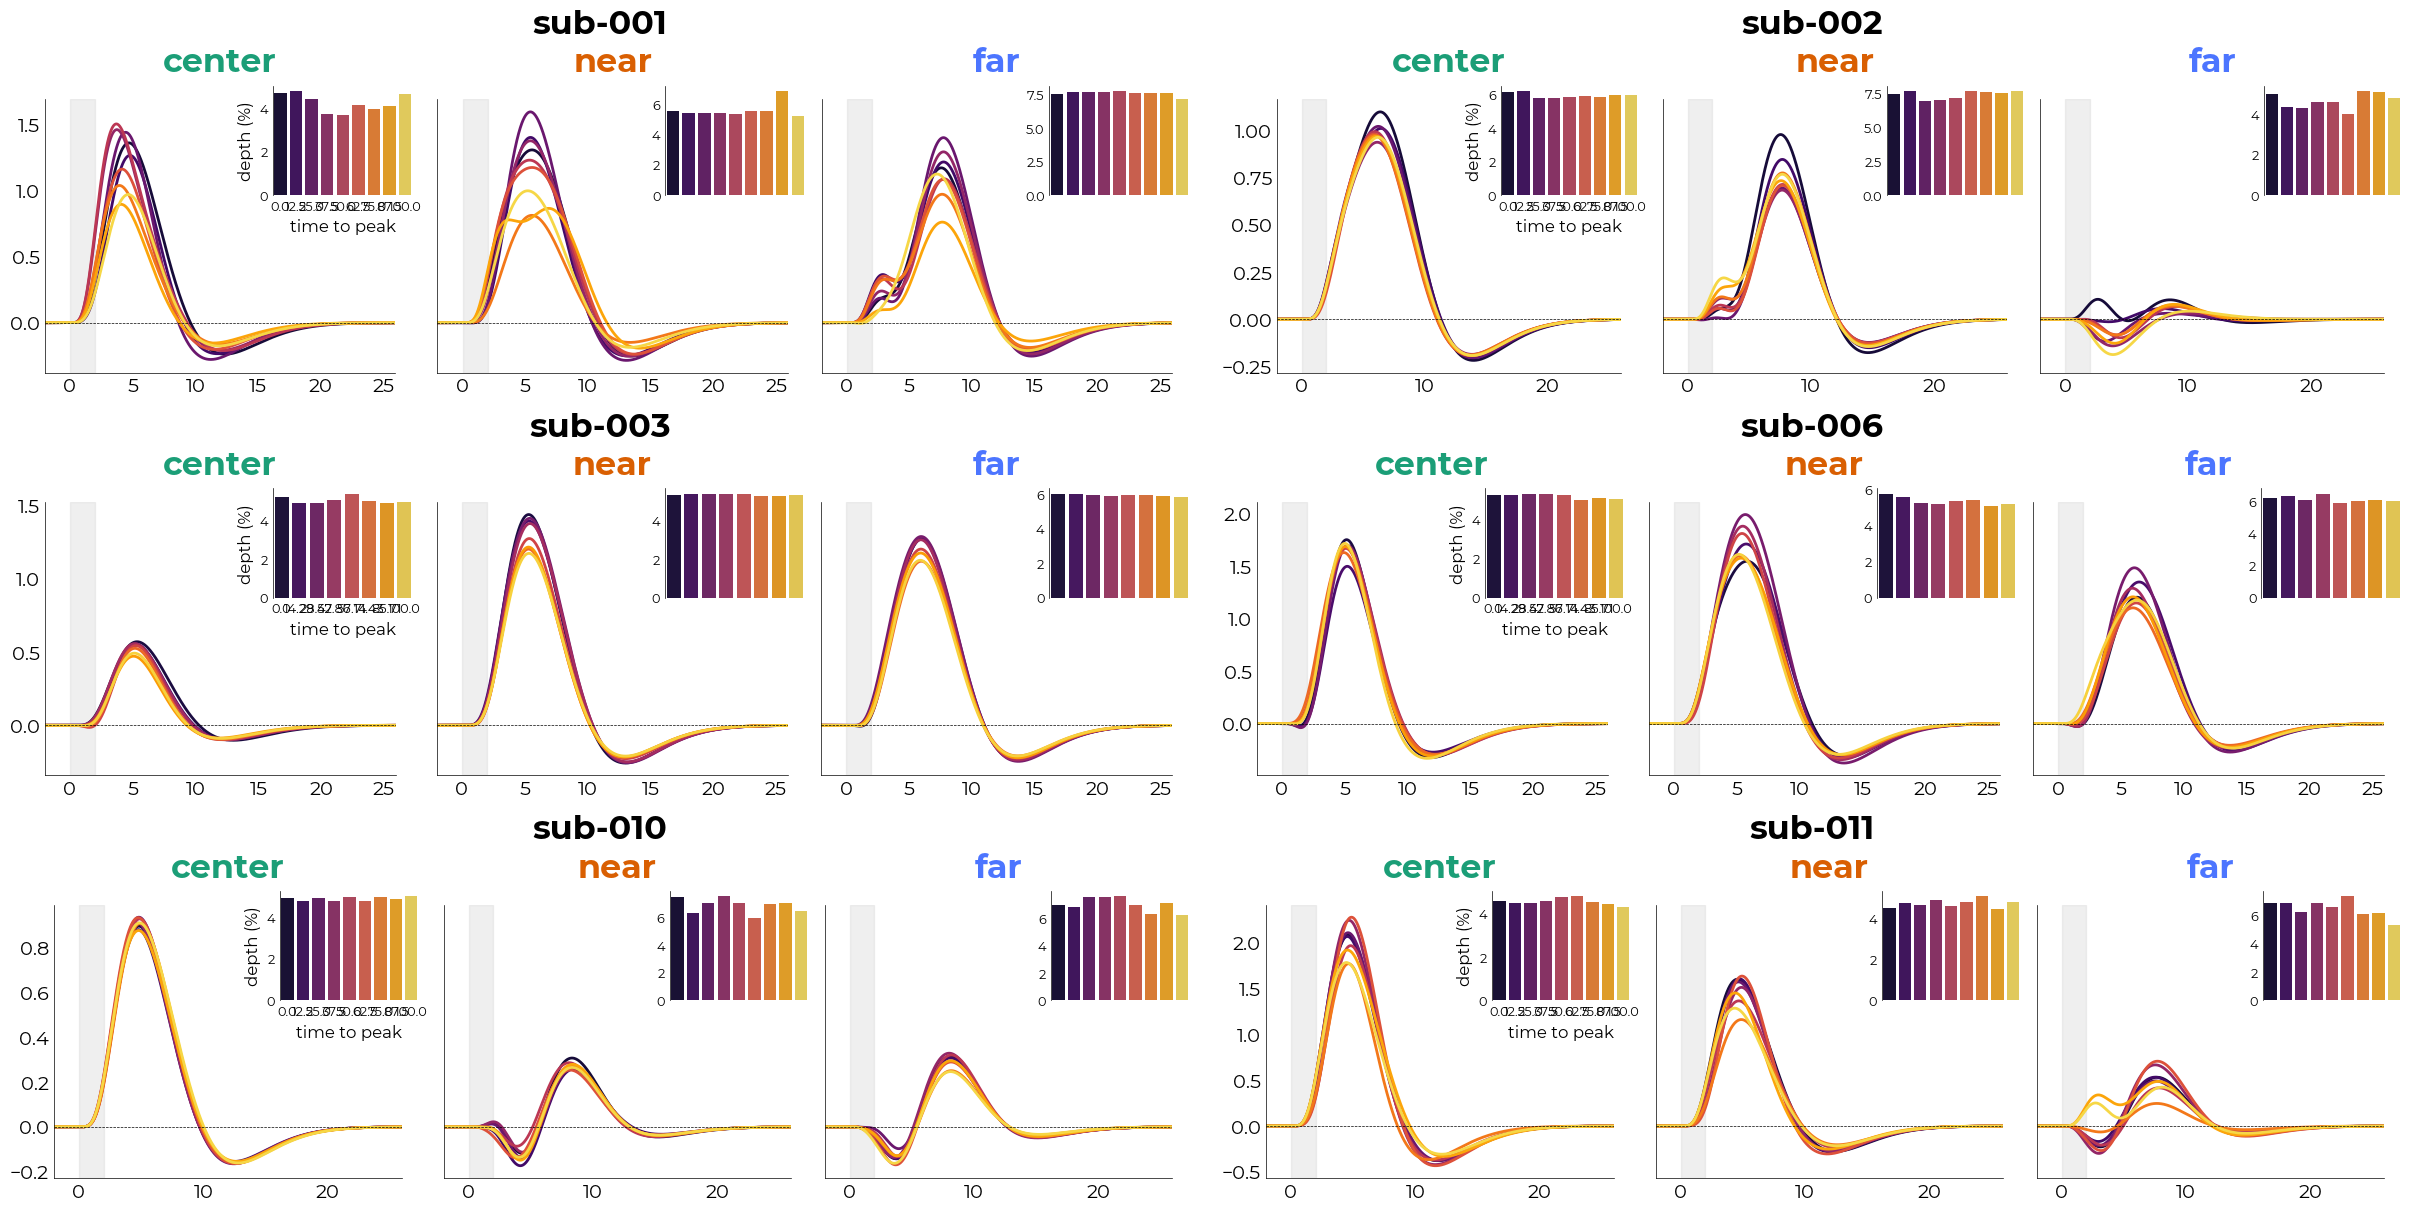

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))
fig = plt.figure(figsize=(24,nrows*4), constrained_layout=True)

sf = fig.subfigures(ncols=ncols, nrows=nrows).flatten()
for ix,(sub,model) in enumerate(models.items()):
    axs = sf[ix].subplots(ncols=len(model.cond), sharey=True)
    dec_profs = hr.viz.PlotDeconvProfiles(
        model,
        axs=axs,
        ttp_lines=False,
        ev_names=["center","near","far"],
        ev_colors=subj_obj.get_colors(),
        bold_title=True,
    )

    sf[ix].suptitle(sub, fontsize=24, fontweight="bold")
hr.viz._save_figure(fig, fname="group_desc-depth_deconv_subjects")    

### Save timecourses + predictions

In [21]:
# # fit
# can_fit = fitting.NideconvFitter(
#     ff,
#     oo,
#     basis_sets='canonical_hrf_with_time_derivative_dispersion',
#     # basis_sets="fourier",
#     # n_regressors=4,
#     TR=0.105,
#     interval=[-2,26],
#     verbose=True,
#     conf_intercep=True,
# )

In [22]:
import seaborn as sns

ev_names = ["center","near","far"]
for subID in subj_obj.get_subjects():
    print(f"Dealing with {subID}")
    sesID = subj_obj.get_session(subID)
    use_model = models[subID]
    runIDs = utils.get_unique_ids(use_model.func, id="run")

    fig,axs = plt.subplots(nrows=len(runIDs), figsize=(14,4*len(runIDs)), constrained_layout=True)
    for ix,run in enumerate(runIDs):
        d_ev = utils.select_from_df(use_model.func, expression=f"run = {run}").mean(axis=1).values

        tcs = [d_ev]
        labels = ["data"]
        for ev_ix,ev in enumerate(use_model.cond):

            p_ev = utils.select_from_df(use_model.ev_predictions, expression=(f"run = {run}","&",f"event_type = {ev}")).mean(axis=1).values
            tcs.append(p_ev)
            labels += [ev_names[ev_ix]]
        
        if len(runIDs)<2:
            ax = axs
        else:
            ax = axs[ix]

        pl = plotting.LazyPlot(
            tcs,
            line_width=[0.5,3,3,3],
            color=["#cccccc"]+subj_obj.get_colors(),
            x_label="volumes",
            y_label="magnitude",
            add_hline=0,
            axs=ax,
            labels=labels,
            # y_lim=[-2.5,2.5],
            title=f"run-{run}"
        )

    fig.suptitle(subID, fontweight="bold", fontsize=pl.title_size*1.3)
    hr.viz._save_figure(
        fig, 
        subject=subID, 
        fname=f"sub-{subID.split('-')[-1]}_ses-{sesID}_desc-timecourses_filt"
    )

    plt.close()

Dealing with sub-001
Dealing with sub-002
Dealing with sub-003
Dealing with sub-005
Dealing with sub-006
Dealing with sub-010
Dealing with sub-011
Dealing with sub-013
Dealing with sub-014
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-014/sub-sub-014_ses-2_desc-timecourses_filt.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-014/sub-sub-014_ses-2_desc-timecourses_filt.png'


### Deconvolve the averages over tasks

In [ ]:
avg_task = utils.select_from_df(utils.multiselect_from_df(h5_obj.df_avg, expression=["subject = 011"]).groupby(["task","t"]).mean(), expression="task = SRFa")
avg_task

avg
task t                
SRFa 0.000   -1.304517
     0.105   -1.454216
     0.210   -1.910267
     0.315   -1.592387
     0.420   -1.808607
...                ...
     377.475 -0.878023
     377.580 -0.456040
     377.685 -0.218285
     377.790  0.146121
     377.895 -0.480830

[3600 rows x 1 columns]

In [ ]:
avg_tasks = h5_obj.df_comps.groupby(["subject","task","t"]).mean()
avg_tasks.head()

0         1         2         3         4
subject task t                                                      
001     SRFb 0.000 -0.070786 -0.004818  0.835636  1.140274 -1.369431
             0.105 -0.330341  0.139111  0.568504 -0.504185 -0.550797
             0.210 -1.539955 -1.806740 -1.990498  0.129398  0.227997
             0.315 -0.560143 -0.033390 -0.100903 -1.250237 -0.678383
             0.420  0.211964 -0.500866 -0.891430  0.659637 -0.501732

In [ ]:
sub_ids = utils.get_unique_ids(avg_tasks, id="subject")
onsets_task_avg = []
for sub in sub_ids:
    sub_df = utils.select_from_df(avg_tasks, expression=f"subject = {sub}")
    task_id = utils.get_unique_ids(sub_df, id="task")

    sub_tasks = []
    for task in task_id:
        task_onsets = utils.select_from_df(h5_obj.df_onsets, expression=(f"subject = {sub}","&",f"task = {task}"))
        runs_in_task = utils.get_unique_ids(task_onsets, id="run")[0]
        run_task = utils.select_from_df(task_onsets, expression=f"run = {runs_in_task}").reset_index()
        run_task.drop(["run"], inplace=True, axis=1)
        onsets_task_avg.append(run_task.set_index(["subject","task","event_type"]))

filt_onsets = pd.concat(onsets_task_avg)
filt_onsets.head()

onset
subject task event_type           
001     SRFb suppr_2     30.015976
             suppr_1     46.332903
             act         66.732840
             act         82.882682
             suppr_2     99.365912

In [ ]:
task_models = {}
for task in ["SRFa","SRFb"]:
    expr = f"task = {task}"

    ffunc = utils.select_from_df(avg_tasks, expression=expr)
    fonsets = utils.select_from_df(filt_onsets, expression=expr)

    inputs = {}
    for tag,df,idx in zip(['func','onsets'],[ffunc,fonsets],[["subject","t"],["subject","event_type"]]):
        df.reset_index(inplace=True)
        df.drop(["task"], inplace=True, axis=1)
        df.set_index(idx, inplace=True)
        inputs[tag] = df.copy()

    mmodel = fitting.NideconvFitter(
        inputs["func"],
        inputs["onsets"],
        basis_sets='canonical_hrf_with_time_derivative_dispersion',
        TR=0.105,
        interval=[-2,26],
        verbose=True,
        conf_intercept=True
    )
    mmodel.timecourses_condition()
    mmodel.parameters_for_tc_subjects()
    mmodel.pars_subjects["task"] = task
    task_models[task] = mmodel

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
|████████████████████████████████████████| 5/5 [100%] in 0.4s (12.25/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (13.57/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (17.55/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (17.34/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.4s (12.99/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (17.01/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.4s (11.45/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.4s (13.09/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.4s (13.06/s)         
|████████████████████████████████████████| 5/5 [100%] 

In [ ]:
# # combine task-models
# comb_df = pd.concat([task_models["SRFa"].pars_subjects,task_models["SRFb"].pars_subjects])
# old_ix = list(comb_df.index.names)
# new_ix = old_ix.copy()
# new_ix.insert(1, "task")

# comb_df.reset_index(inplace=True)
# comb_df.set_index(new_ix, inplace=True)

# # average over tasks
# comb_df.concat_pars = comb_df.groupby(old_ix).mean()

|████████████████████████████████████████| 5/5 [100%] in 0.4s (12.51/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (19.08/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (13.13/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (17.56/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (17.52/s)         
|████████████████████████████████████████| 5/5 [100%] in 0.3s (13.23/s)         


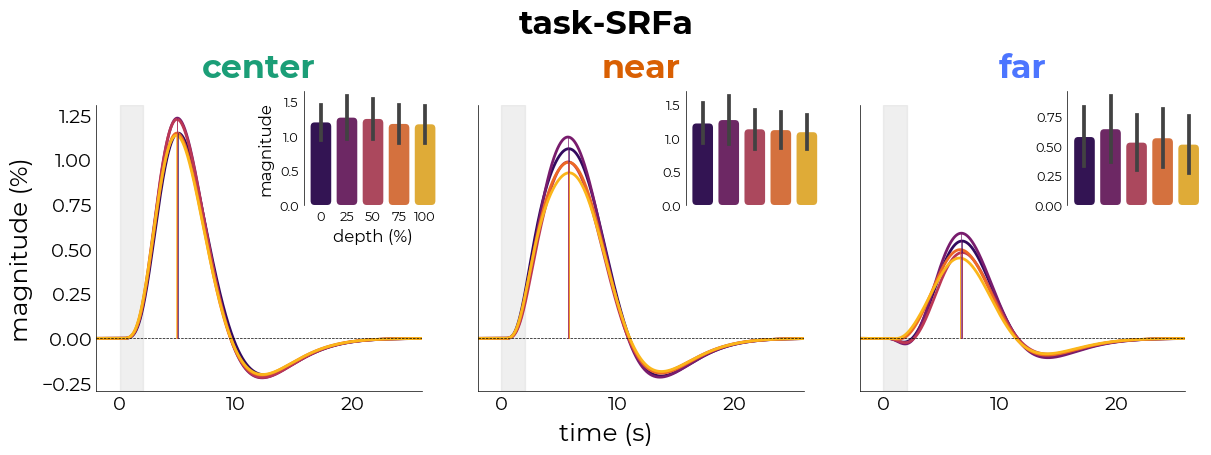

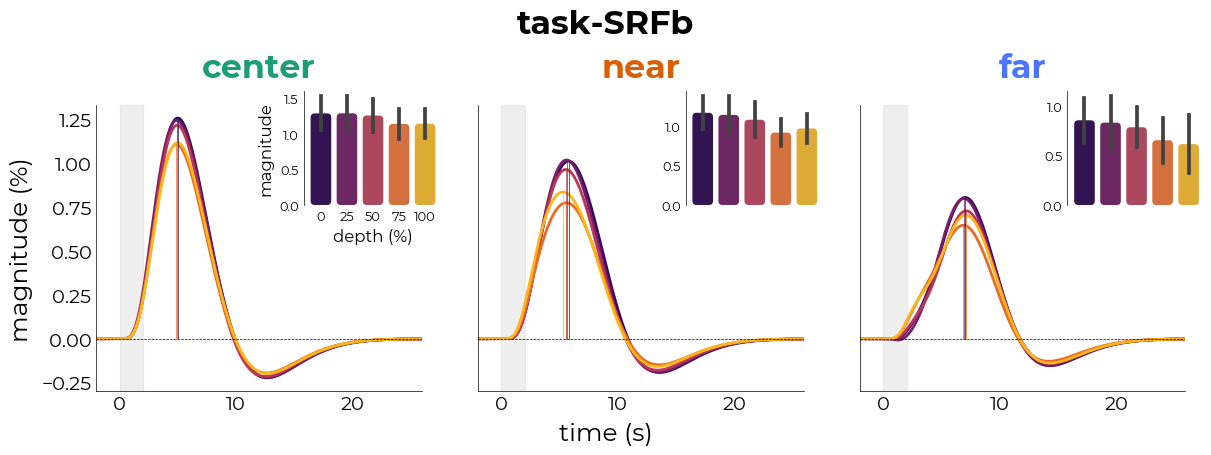

In [ ]:
for key,val in task_models.items():
    dec_comp = hr.viz.PlotDeconvProfiles(
        val,
        inset_kwargs={
            "fancy": True,
            # "fancy_denom": 3,
            "sns_offset": 3,
            # "add_points": True,
            "sns_ori": "v"
        },
        title=f"task-{key}",
        ev_names=["center","near","far"],
        ev_colors=subj_obj.get_colors(),
        bold_title=True,
        err="sem",
        inset_par="magnitude",
        force_int=True
    )

    # hr.viz._save_figure(dec_comp.fig, fname="group_desc-depth_deconv")